# Demo notebook for Huawei Public 2025 data release

This notebook explains how to load an analyze the Huawei Public 2025 data.

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from glob import glob
from tqdm import tqdm
import seaborn as sns
import gc
sns.set_theme()

Always run this cell to set up

In [12]:
# Define regions we want to analyze
region_names = ['R1', 'R2', 'R3', 'R4', 'R5']

# Define root for quantiles
rt = '../datasets/cold_start_dataset/quantiles'

# Define root for cold starts
rt_cold_start = '../datasets/cold_start_dataset/cold_start'

# Define root for runtime and trigger type file
rt_funcID_runtime_triggerType = '../datasets/cold_start_dataset/runtime_triggerType/df_funcID_runtime_triggerType.csv'

## CDFs of cold starts per region

In [3]:
# Read cold starts
df_list_outer = []
for region_name_i in region_names:
    print(f'Reading {region_name_i}')
    filenames_list_i = sorted(glob(rt_cold_start+f'/{region_name_i}/*.csv'))
    dfs_list = []
    for filename_i in tqdm(filenames_list_i):
        df_i = pd.read_csv(filename_i)
        dfs_list.append(df_i)
    df_xx = pd.concat(dfs_list)
    df_xx['region'] = region_name_i
    df_list_outer.append(df_xx)
    del dfs_list, df_xx 
    gc.collect()

df_all_cold_starts = pd.concat(df_list_outer)

Reading R1


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:22<00:00,  1.39it/s]


Reading R2


100%|██████████| 31/31 [00:04<00:00,  6.52it/s]


Reading R3


100%|██████████| 31/31 [00:00<00:00, 43.48it/s]


Reading R4


100%|██████████| 31/31 [00:03<00:00,  8.98it/s]


Reading R5


100%|██████████| 31/31 [00:01<00:00, 18.52it/s]


<Axes: xlabel='totalCost_cold_start', ylabel='Probability'>

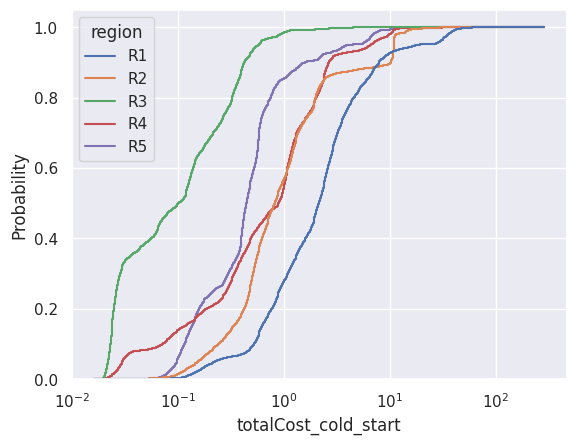

In [4]:
# Plot of cold start times per region

sns.histplot(data=df_all_cold_starts, 
             bins=500,
             fill=False,
             element="step",
             x='totalCost_cold_start', 
             hue='region', 
             stat='probability', 
             cumulative=True, 
             log_scale=[True,False], 
             common_norm=False)

## Plotting time series and quantiles

In [3]:
region_name_i = 'R2'

In [4]:
rt_requests = f'{rt}/{region_name_i}/requests/*.csv'
filenames_i = sorted(glob(rt_requests))
print(f'Found {len(filenames_i)} requests files')

Found 31 requests files


In [5]:
# Select number of days to read (or None to read all)

n_days = None

dfs_list = []
for f_i in tqdm(filenames_i[:n_days]):
    df = pd.read_csv(f_i)
    dfs_list.append(df)
df_requests = pd.concat(dfs_list)
df_requests

100%|██████████| 31/31 [00:09<00:00,  3.36it/s]


day     time  400---418---pool22-300-128  1531---418---pool22-300-128  \
0       0        0                         1.0                          NaN   
1       0       60                         NaN                          NaN   
2       0      120                         NaN                          NaN   
3       0      180                         1.0                          NaN   
4       0      240                         NaN                          NaN   
...   ...      ...                         ...                          ...   
1435   30  2678100                         NaN                          NaN   
1436   30  2678160                         NaN                          NaN   
1437   30  2678220                         1.0                          NaN   
1438   30  2678280                         NaN                          NaN   
1439   30  2678340                         NaN                          NaN   

      343---1077---pool22-300-128  343---192---pool22-300-128  \
0                             NaN                         2.0   
1                             NaN                         NaN   
2                             NaN                         NaN   
3                             NaN                         NaN   
4                             NaN                         NaN   
...                           ...                         ...   
1435                          NaN                         NaN   
1436                          NaN                         NaN   
1437                          NaN                         NaN   
1438                          NaN                         NaN   
1439                          NaN                         NaN   

      343---974---pool22-300-128  343---952---pool22-300-128  \
0                            NaN                         NaN   
1                            NaN                         NaN   
2                            NaN                         NaN   
3                            NaN                         NaN   
4                            NaN                         NaN   
...                          ...                         ...   
1435                         NaN                         NaN   
1436                         NaN                         NaN   
1437                         NaN                         NaN   
1438                         NaN                         NaN   
1439                         NaN                         NaN   

      343---107---pool22-300-128  1263---582---pool23-400-256  ...  \
0                            NaN                          NaN  ...   
1                            NaN                          3.0  ...   
2                            NaN                          3.0  ...   
3                            NaN                          1.0  ...   
4                            NaN                          1.0  ...   
...                          ...                          ...  ...   
1435                         NaN                          NaN  ...   
1436                         NaN                          3.0  ...   
1437                         NaN                          NaN  ...   
1438                         NaN                          2.0  ...   
1439                         NaN                          NaN  ...   

      2072---592---pool22-300-128  1835---1027---pool22-300-128  \
0                             NaN                           NaN   
1                             NaN                           NaN   
2                             NaN                           NaN   
3                             NaN                           NaN   
4                             NaN                           NaN   
...                           ...                           ...   
1435                          NaN                           NaN   
1436                          NaN                           NaN   
1437                          NaN                           NaN

In [6]:
# Identify unique functions 
funcIDs_list = list(df_requests.columns)
funcIDs_list.remove('day')
funcIDs_list.remove('time')

# Create dataframe with funcIDs
df_summary = df_requests[funcIDs_list].sum().reset_index().rename({'index':'funcID', 0: 'requests'}, axis=1)

# First part of funcID is funcName
df_summary['funcName'] = df_summary['funcID'].str.split('---').str[0].astype(int)

# Second part of funcID is userID
df_summary['userID'] = df_summary['funcID'].str.split('---').str[1].astype(int)

# Third part of funcID is poolName
df_summary['poolName'] = df_summary['funcID'].str.split('---').str[2]

# poolName contains the cpu_limit (in millicores) and memory_limit (in MB) assigned to this function
df_summary['cpu_limit']= df_summary['poolName'].str.split('-').str[1].astype(int)
df_summary['memory_limit']= df_summary['poolName'].str.split('-').str[2].astype(int)

df_summary = df_summary.sort_values(by='requests', ascending=False)

df_summary

funcID      requests  funcName  userID  \
1213  88---337---pool26-1000-1024  8.531371e+09        88     337   
1342  1529---631---pool23-400-256  1.172783e+09      1529     631   
1348  1118---631---pool24-600-512  1.145816e+09      1118     631   
978   1542---502---pool22-300-128  3.984803e+08      1542     502   
975   1179---502---pool23-400-256  3.984757e+08      1179     502   
...                           ...           ...       ...     ...   
2353  1642---478---pool22-300-128  1.000000e+00      1642     478   
2388   220---797---pool22-300-128  1.000000e+00       220     797   
2377  1269---330---pool22-300-128  1.000000e+00      1269     330   
2386  1749---4---pool35-6600-8192  1.000000e+00      1749       4   
2384   677---842---pool22-300-128  1.000000e+00       677     842   

              poolName  cpu_limit  memory_limit  
1213  pool26-1000-1024       1000          1024  
1342    pool23-400-256        400           256  
1348    pool24-600-512        600           512  
978     pool22-300-128        300           128  
975     pool23-400-256        400           256  
...                ...        ...           ...  
2353    pool22-300-128        300           128  
2388    pool22-300-128        300           128  
2377    pool22-300-128        300           128  
2386  pool35-6600-8192       6600          8192  
2384    pool22-300-128        300           128  

[2418 rows x 7 columns]

In [8]:
# We consider funcID to be the unique function identifier
for colname in ['funcID', 'funcName', 'userID', 'poolName']:
    n_unique_i = df_summary[colname].nunique()
    print(f'{colname} has {n_unique_i} unique values')

funcID has 2418 unique values
funcName has 2148 unique values
userID has 1144 unique values
poolName has 27 unique values


In [9]:
# Mapping of cpu_limit to cpu_request
dict_cpu_lim_to_req = {300: 100, 400: 125, 600: 300, 800: 375, 
                        1000: 500, 1200: 625, 1400: 750, 
                        1600: 875, 1800: 1000, 2200: 1250,
                        2600: 1500, 3000: 1750, 3400: 2000, 
                        6600: 4000, 8200: 5000, 13000: 6500, 25800: 12900}

In [10]:
quantiles_list = [0, 25, 50, 90, 100, 'avg', 'std']

quantiles_list = [f'quantile_{item:003}' if isinstance(item, int) else item for item in quantiles_list]

print(quantiles_list)

metrics_dict = {
    'cpu_usage': dict.fromkeys(quantiles_list),
}

['quantile_000', 'quantile_025', 'quantile_050', 'quantile_090', 'quantile_100', 'avg', 'std']


In [11]:
# Read quantiles
n_days = 3

metric_family_list = sorted(list(metrics_dict.keys()))

for metric_family in metric_family_list:
    print(metric_family)
    metric_subfamily_list = sorted(list(metrics_dict[metric_family].keys()))

    for submetric in tqdm(metric_subfamily_list):
        if submetric=='sum':
            rt_i = f'{rt}/{region_name_i}/{metric_family}/*.csv'
        else:
            rt_i = f'{rt}/{region_name_i}/{metric_family}_{submetric}/*.csv'

        filenames_i = sorted(glob(rt_i))

        dfs_list_i = []
        for f_i in filenames_i[:n_days]:
            df_ii = pd.read_csv(f_i)
            dfs_list_i.append(df_ii)
        df_i = pd.concat(dfs_list_i)

        metrics_dict[metric_family][submetric] = df_i


cpu_usage


100%|██████████| 7/7 [00:05<00:00,  1.21it/s]


In [12]:
funcID = '137---631---pool23-400-256'

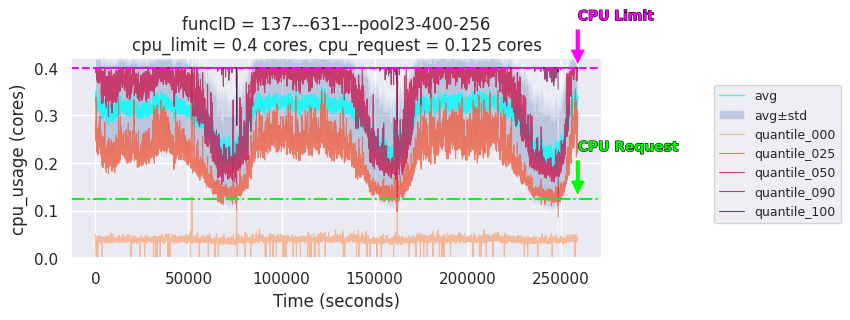

In [13]:
cpu_limit_cores = float(funcID.split('---')[-1].split('-')[1])/1000
cpu_request_cores = dict_cpu_lim_to_req[int(cpu_limit_cores*1000)]/1000
alpha = 0.8
linewidth = 0.8
limit_color='magenta'
request_color='lime'

fig, ax = plt.subplots(1,1,figsize=(9,3.5))

metric_family_dict = metrics_dict['cpu_usage'].copy()

# Avg and std plots
ax.plot(metric_family_dict['avg']['time'], metric_family_dict['avg'][funcID], label = 'avg', c='cyan', alpha=0.8, linewidth=1)

std_upper = metric_family_dict['avg'][funcID] - metric_family_dict['std'][funcID]
std_lower = metric_family_dict['avg'][funcID] + metric_family_dict['std'][funcID]
ax.fill_between(metric_family_dict['avg']['time'], std_lower, std_upper, alpha=0.3, facecolor='b', label='avg±std')


# Quantile plots
q_list = sorted(metric_family_dict.keys())
q_list = [item for item in q_list if 'quantile' in item]

max_ylim = -9999
c_list = sns.color_palette('rocket_r', len(q_list))
for i, q_i in enumerate(q_list):
    df_q_i = metric_family_dict[q_i]
    ax.plot(df_q_i['time'], df_q_i[funcID], label = q_i.replace(metric_family,''), c=c_list[i], alpha=alpha, linewidth=linewidth)

    max_ylim_i = df_q_i[funcID].quantile(0.99)
    if max_ylim<max_ylim_i:
        max_ylim = max_ylim_i

ax.set_xlabel('Time (seconds)')

ax.legend(bbox_to_anchor=(1.2, 0.9), fontsize=9)

ax.set_ylim(None, max_ylim*1.05)
if ax.get_ylim()[0]<0:
    ax.set_ylim(0, max_ylim*1.05)

ax.set_ylabel('cpu_usage (cores)')

# Horizontal lines
plt.axhline(y=cpu_limit_cores, color=limit_color, linestyle='--', label='CPU Limit')
plt.axhline(y=cpu_request_cores, color=request_color, linestyle='-.', label='CPU Request')

# Add arrow and labels for "CPU Limit"
annotation = plt.annotate('CPU Limit', 
            xy=(metric_family_dict['avg']['time'].iloc[-1], cpu_limit_cores), 
            xytext=(metric_family_dict['avg']['time'].iloc[-1] + 0.5, cpu_limit_cores + 0.1),
            arrowprops=dict(facecolor=limit_color, shrink=0.05), fontsize=10, color=limit_color, fontweight='heavy')
# Add a black outline to the text
annotation.set_path_effects([path_effects.Stroke(linewidth=0.8, foreground='black'), 
                             path_effects.Normal()])


# Add arrow and labels for "CPU Request"
annotation = plt.annotate('CPU Request', 
            xy=(metric_family_dict['avg']['time'].iloc[-1], cpu_request_cores), 
            xytext=(metric_family_dict['avg']['time'].iloc[-1] + 0.5, cpu_request_cores + 0.1),
            arrowprops=dict(facecolor=request_color, shrink=0.05), fontsize=10, color=request_color, fontweight='heavy')
# Add a black outline to the text
annotation.set_path_effects([path_effects.Stroke(linewidth=0.8, foreground='black'), 
                             path_effects.Normal()])


title_str = f'funcID = {funcID}\ncpu_limit = {cpu_limit_cores} cores, cpu_request = {cpu_request_cores} cores'

plt.title(title_str)
plt.tight_layout()
plt.show()

Now we extend the plot above to read more metrics more of them

In [14]:
quantiles_list = [0, 50, 90, 95, 'avg', 'std']

quantiles_list = [f'quantile_{item:003}' if isinstance(item, int) else item for item in quantiles_list]

print(quantiles_list)

metrics_dict = {
    'requests': dict.fromkeys(['sum']),
    'num_pods': dict.fromkeys(['sum']),
    'num_cold_starts': dict.fromkeys(['sum']),
    'cpu_usage': dict.fromkeys(quantiles_list),
    'memory_usage': dict.fromkeys(quantiles_list),

    'totalCost_frontend': dict.fromkeys(quantiles_list),
    'totalCost': dict.fromkeys(quantiles_list),
    'totalCost_cold_start': dict.fromkeys(quantiles_list),

    'workerCost': dict.fromkeys(quantiles_list),
    'frontendCost': dict.fromkeys(quantiles_list),
    'readBodyCost': dict.fromkeys(quantiles_list),

    'writeRspCost': dict.fromkeys(quantiles_list),
    'runtimeCost': dict.fromkeys(quantiles_list),
    'busCost': dict.fromkeys(quantiles_list),

    'requestBodySize': dict.fromkeys(quantiles_list),

    'podAllocationCost': dict.fromkeys(quantiles_list),
    'deployCodeCost': dict.fromkeys(quantiles_list),
    'deployDependencyCost': dict.fromkeys(quantiles_list),
    'schedulingCost': dict.fromkeys(quantiles_list),
}

['quantile_000', 'quantile_050', 'quantile_090', 'quantile_095', 'avg', 'std']


In [15]:
# Read quantiles
n_days = 3

metric_family_list = sorted(list(metrics_dict.keys()))

for metric_family in metric_family_list:
    print(metric_family)
    metric_subfamily_list = sorted(list(metrics_dict[metric_family].keys()))

    for submetric in tqdm(metric_subfamily_list):
        if submetric=='sum':
            rt_i = f'{rt}/{region_name_i}/{metric_family}/*.csv'
        else:
            rt_i = f'{rt}/{region_name_i}/{metric_family}_{submetric}/*.csv'

        filenames_i = sorted(glob(rt_i))

        dfs_list_i = []
        for f_i in filenames_i[:n_days]:
            df_ii = pd.read_csv(f_i)
            dfs_list_i.append(df_ii)
        df_i = pd.concat(dfs_list_i)

        metrics_dict[metric_family][submetric] = df_i


busCost


100%|██████████| 6/6 [00:04<00:00,  1.31it/s]


cpu_usage


100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


deployCodeCost


100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


deployDependencyCost


100%|██████████| 6/6 [00:05<00:00,  1.20it/s]


frontendCost


100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


memory_usage


100%|██████████| 6/6 [00:04<00:00,  1.37it/s]


num_cold_starts


100%|██████████| 1/1 [00:00<00:00,  1.43it/s]


num_pods


100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


podAllocationCost


100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


readBodyCost


100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


requestBodySize


100%|██████████| 6/6 [00:04<00:00,  1.39it/s]


requests


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


runtimeCost


100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


schedulingCost


100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


totalCost


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


totalCost_cold_start


100%|██████████| 6/6 [00:04<00:00,  1.21it/s]


totalCost_frontend


100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


workerCost


100%|██████████| 6/6 [00:05<00:00,  1.09it/s]


writeRspCost


100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


In [16]:
df_top = metrics_dict['requests']['sum'][metrics_dict['requests']['sum'].columns[2:]].sum().reset_index()
df_top = df_top.sort_values(by=0, ascending=False)
df_top

index            0
1213   88---337---pool26-1000-1024  133472184.0
1342   1529---631---pool23-400-256  114966688.0
1348   1118---631---pool24-600-512  112372500.0
978    1542---502---pool22-300-128   54780079.0
975    1179---502---pool23-400-256   54780021.0
...                            ...          ...
1890    1472---19---pool22-300-128          0.0
1921  1677---1031---pool24-600-512          0.0
1920    458---494---pool23-400-256          0.0
1919   2042---953---pool22-300-128          0.0
1897   1201---855---pool22-300-128          0.0

[2418 rows x 2 columns]

In [17]:
funcID_list = df_top['index'].head(10).to_list()
funcID_list

['88---337---pool26-1000-1024',
 '1529---631---pool23-400-256',
 '1118---631---pool24-600-512',
 '1542---502---pool22-300-128',
 '1179---502---pool23-400-256',
 '1413---631---pool22-300-128',
 '612---63---pool22-300-128',
 '1411---741---pool24-600-512',
 '137---631---pool23-400-256',
 '944---173---custom.image.gpu-25800-32768']

  0%|          | 0/10 [00:00<?, ?it/s]


No metrics left


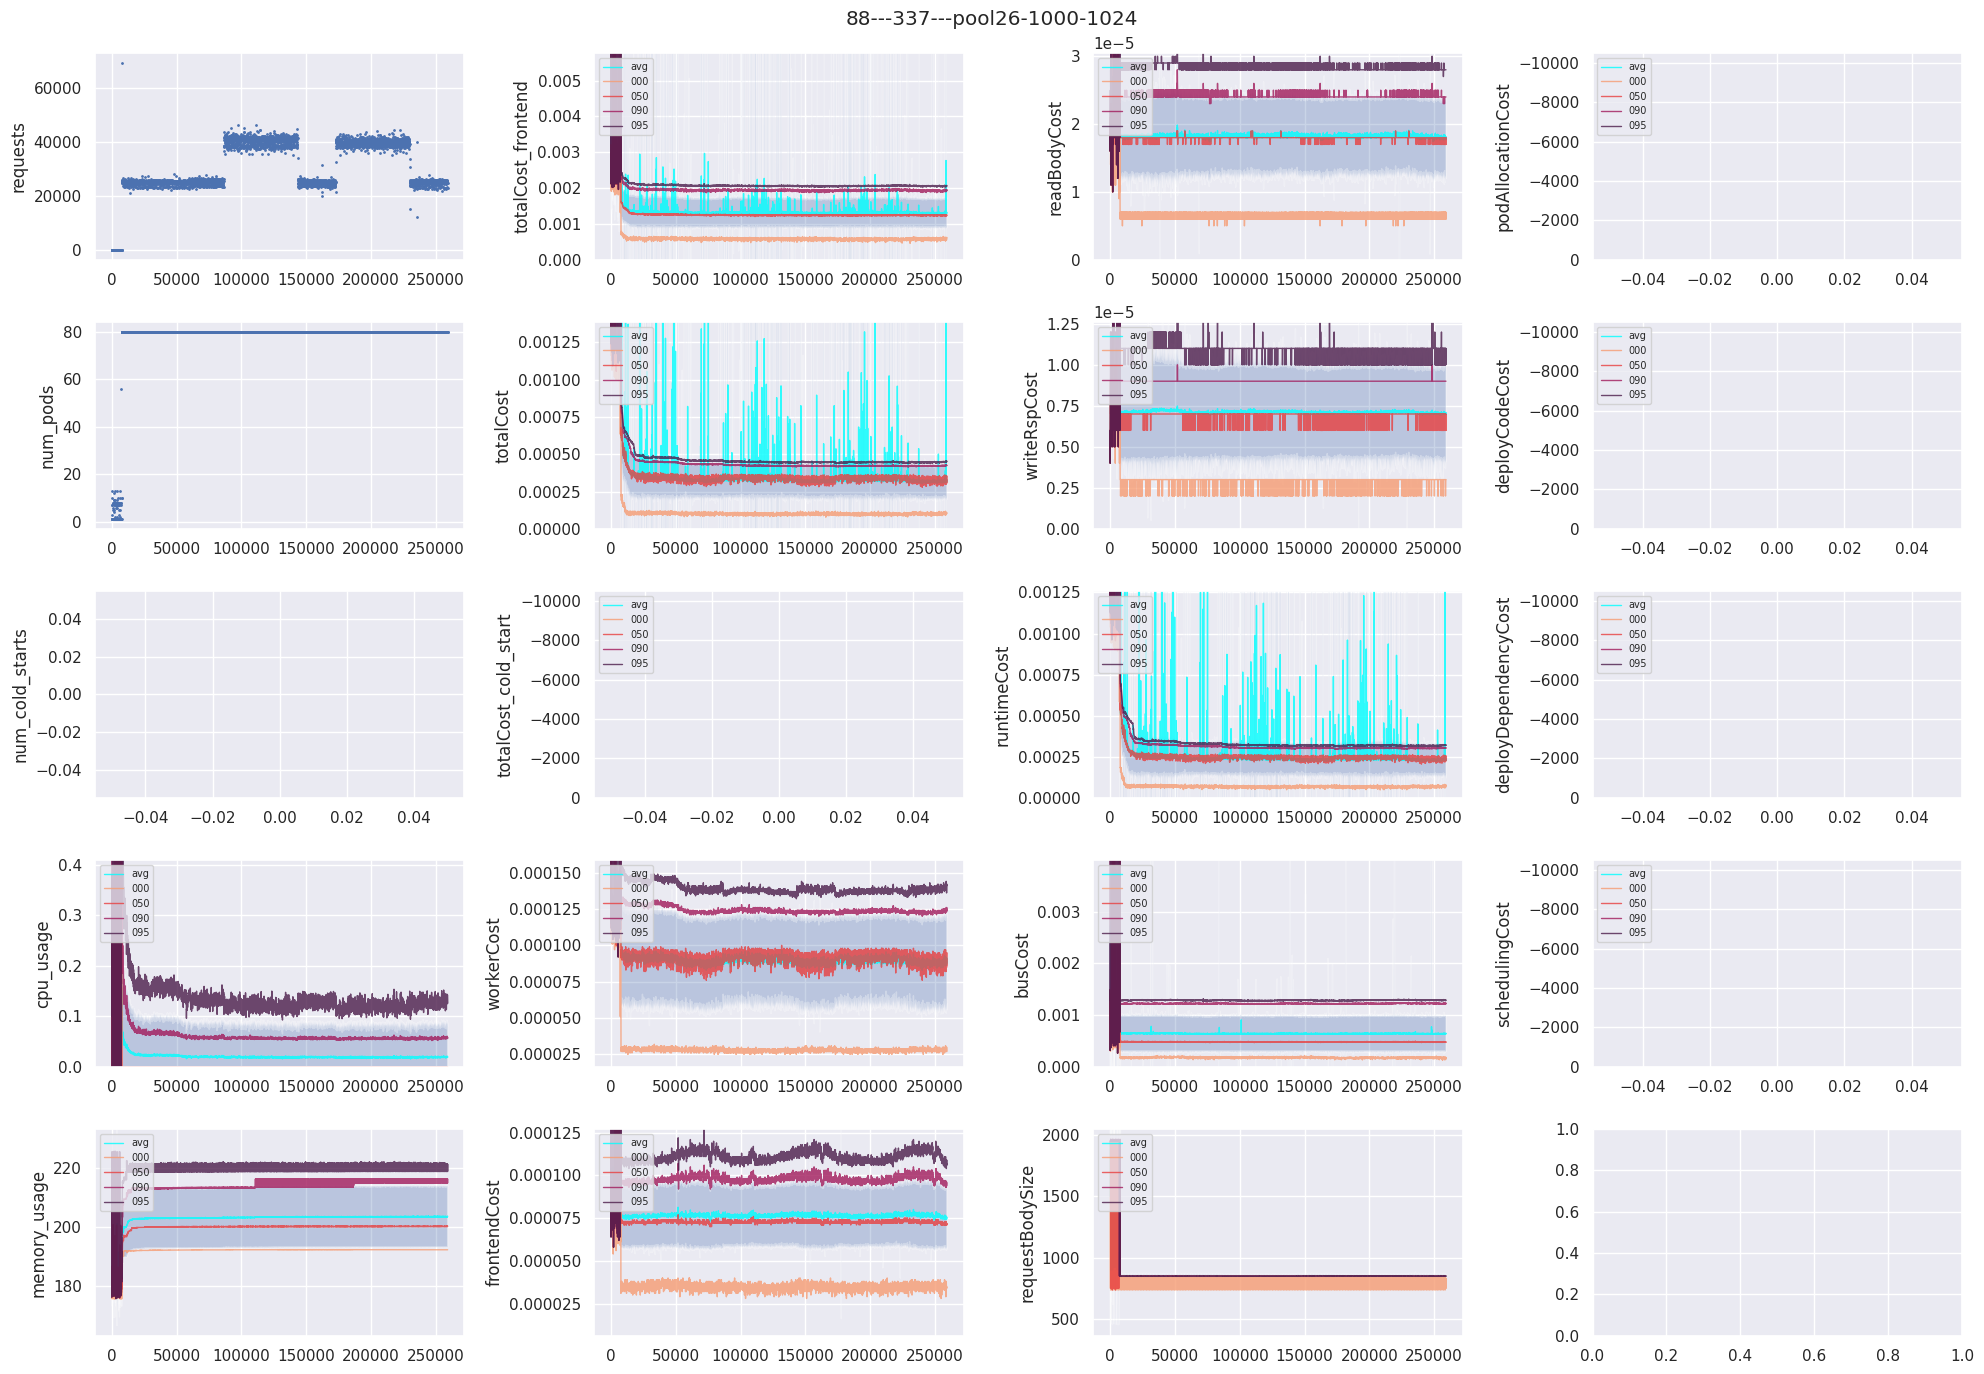

 10%|█         | 1/10 [00:03<00:34,  3.79s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


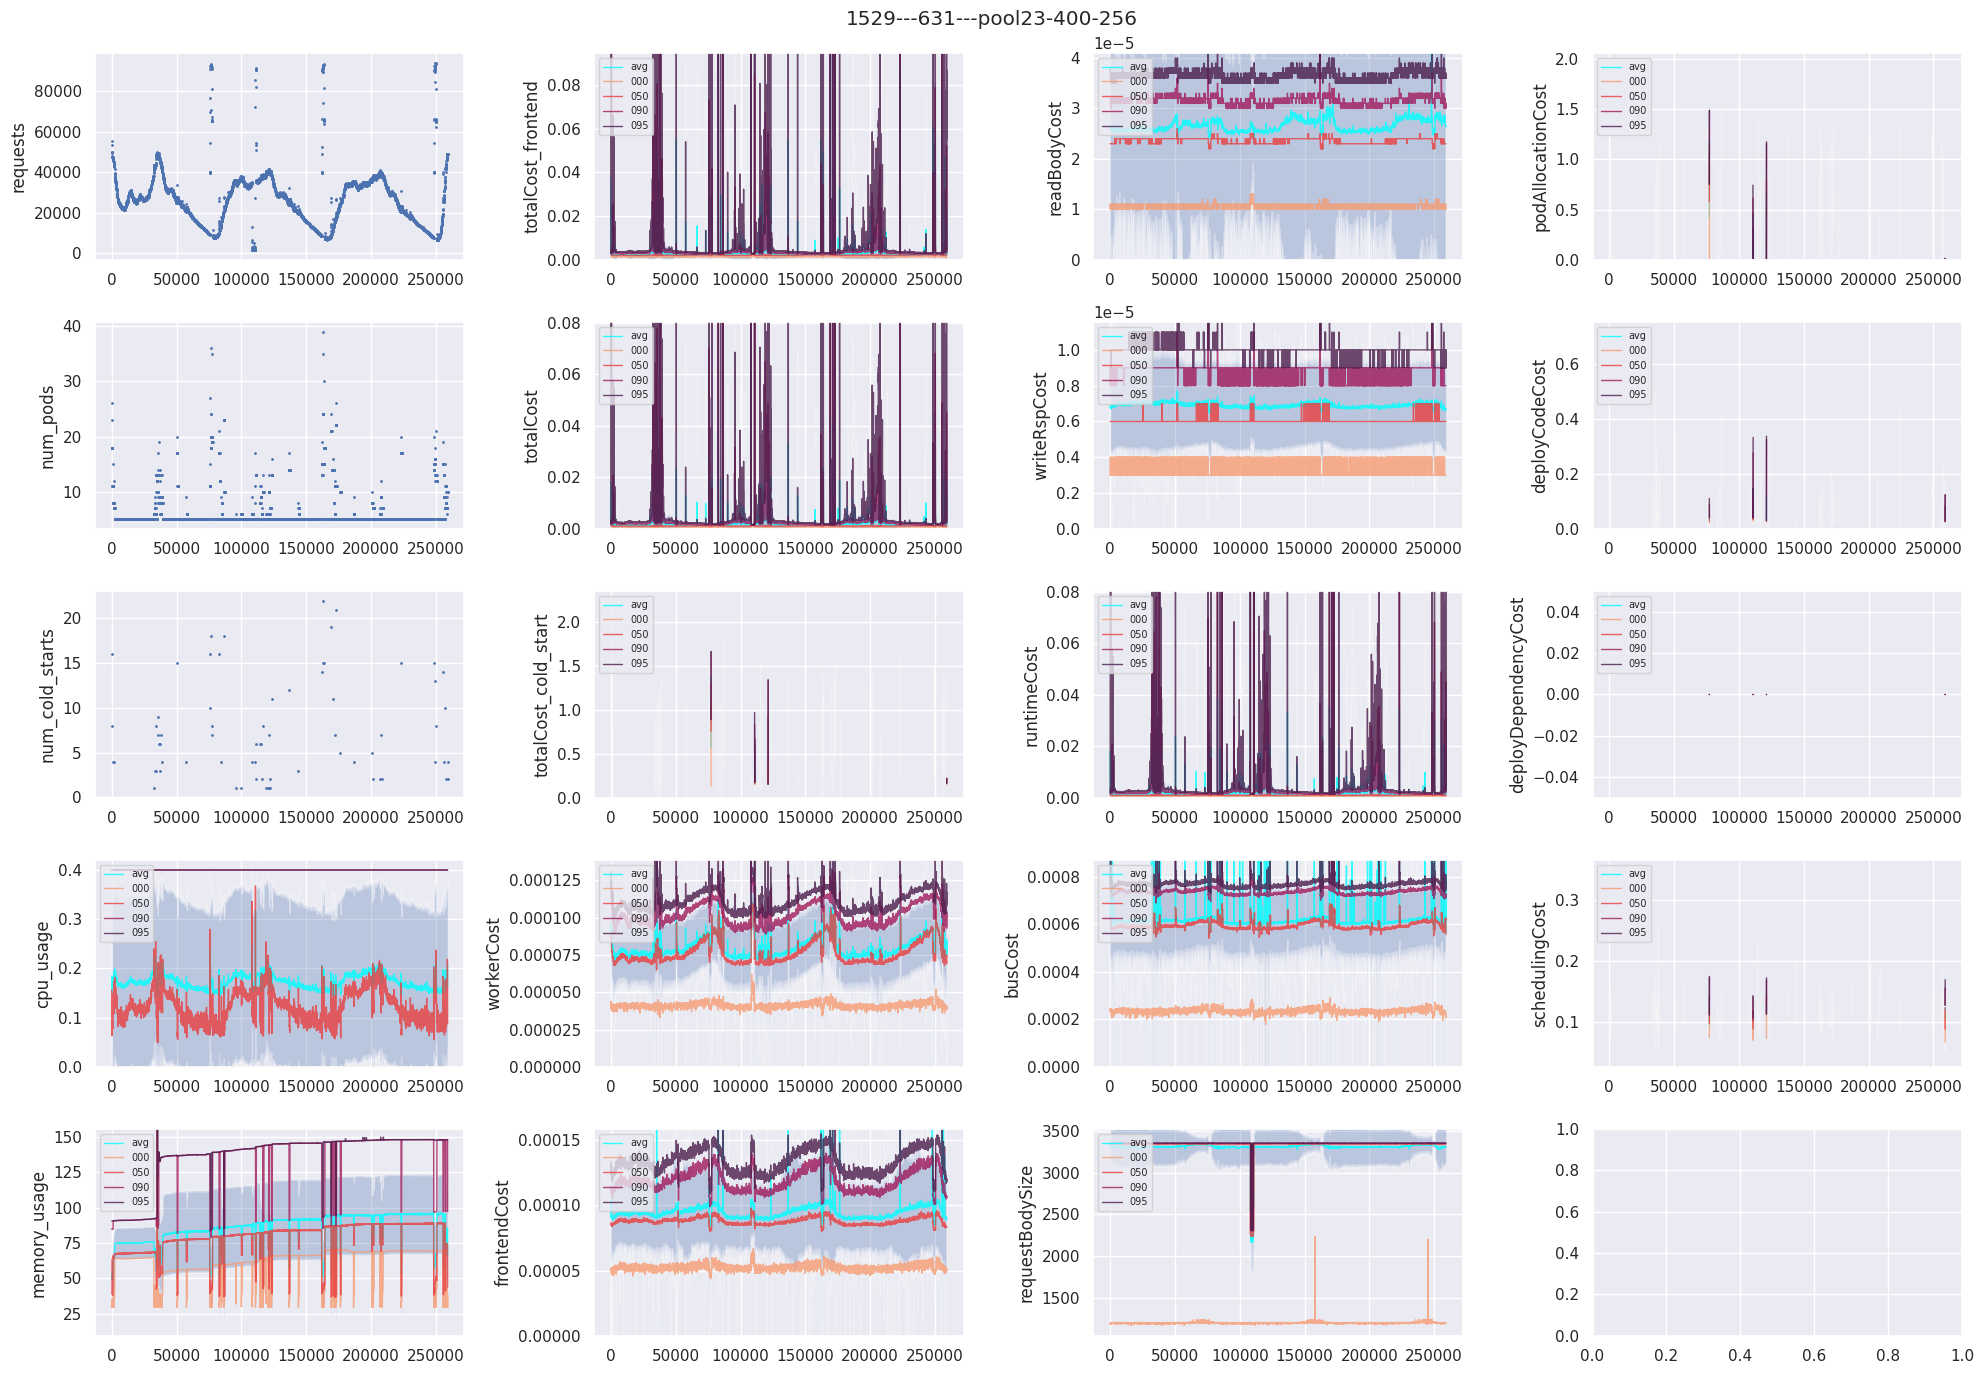

 20%|██        | 2/10 [00:07<00:30,  3.76s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


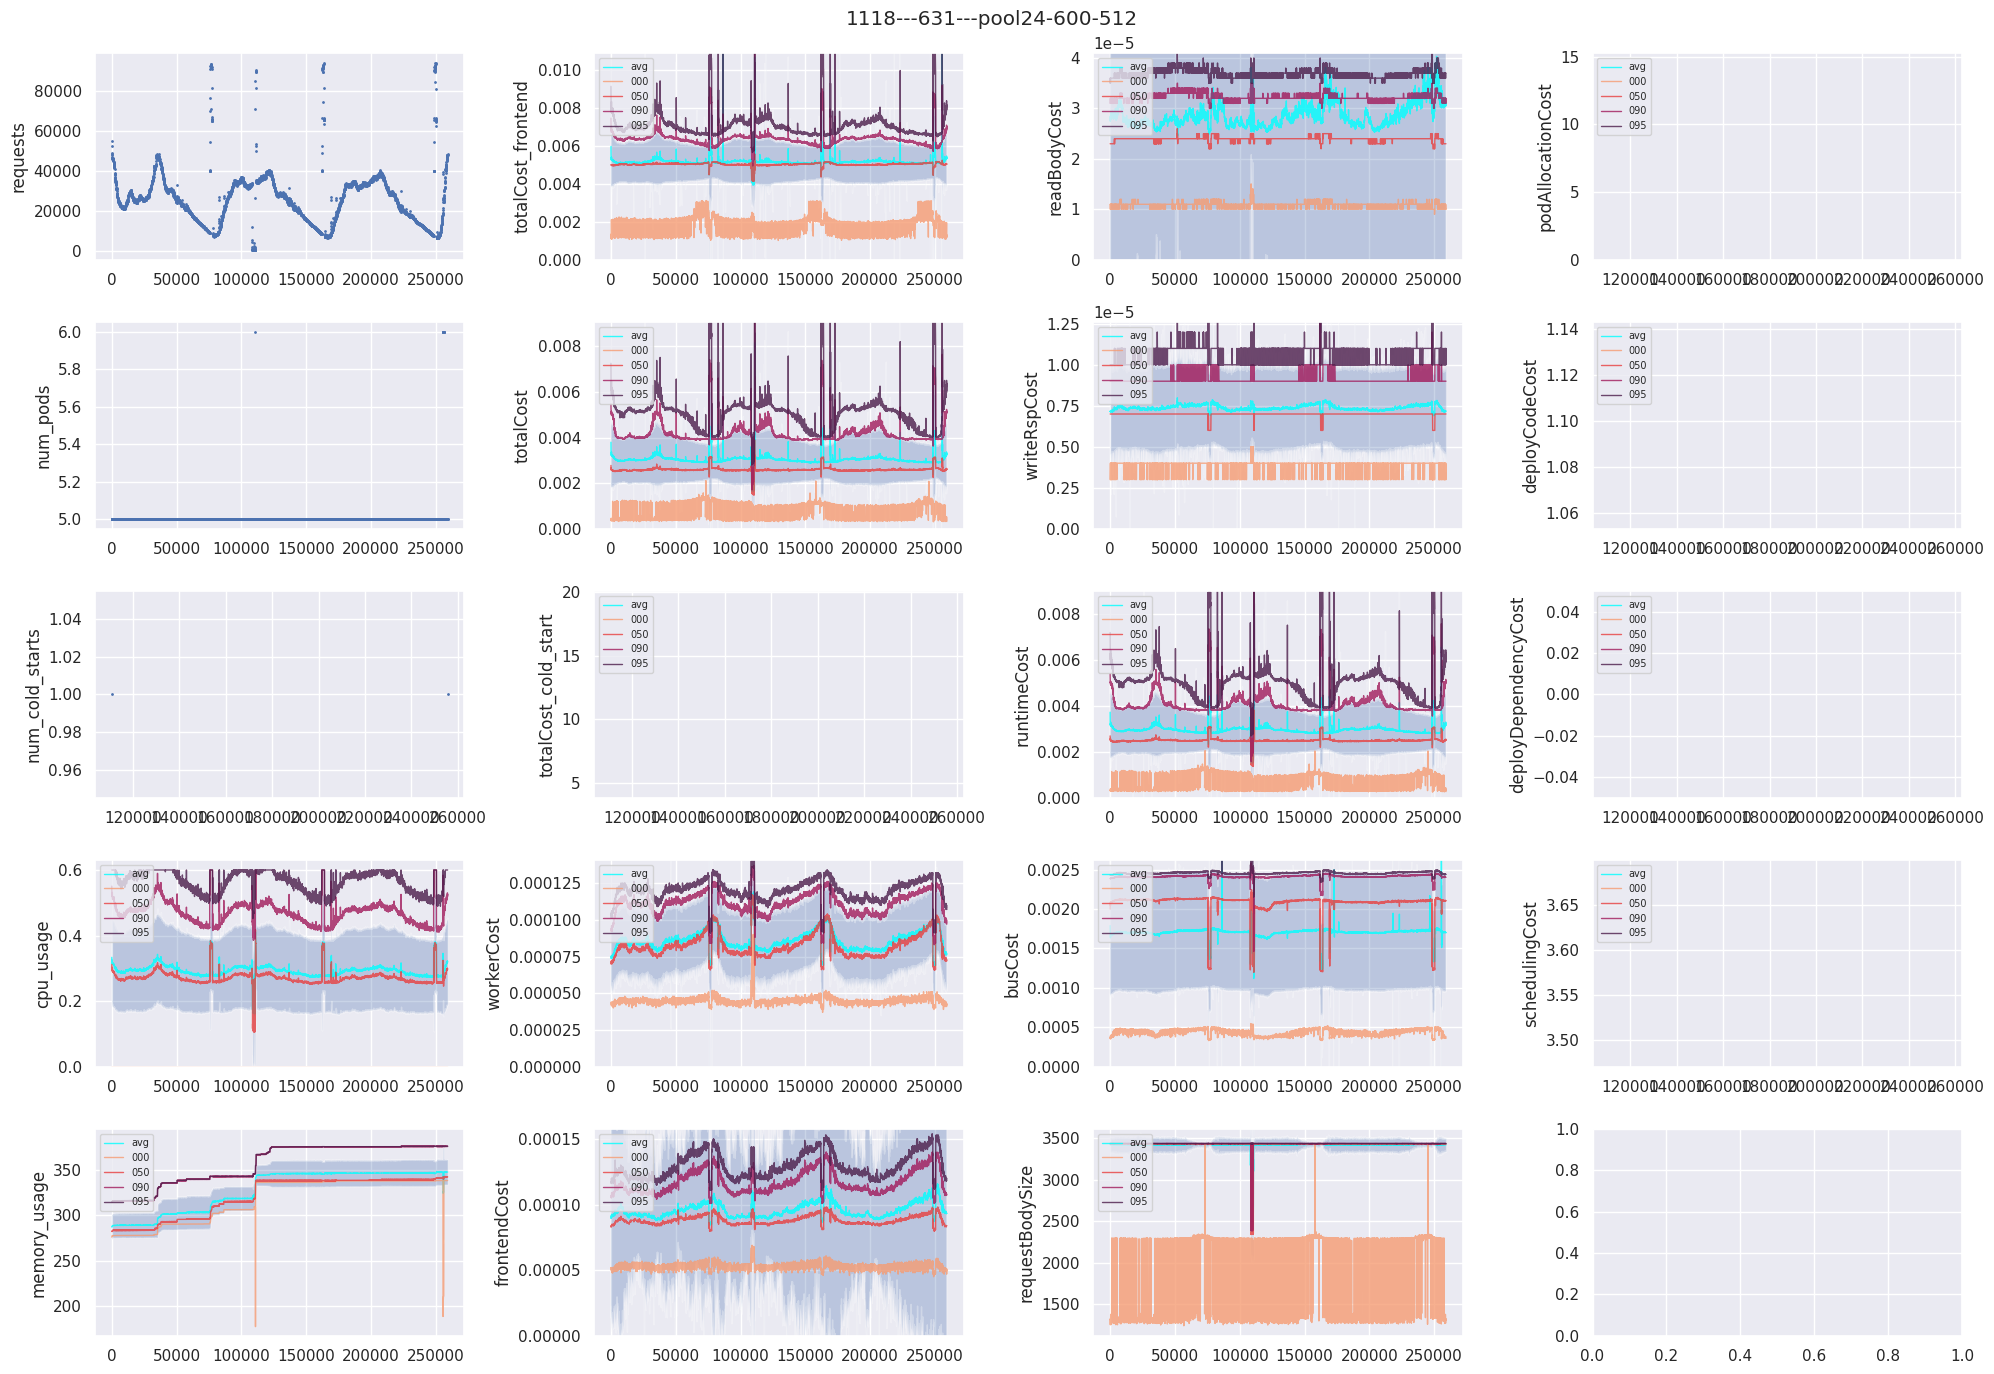

 30%|███       | 3/10 [00:11<00:27,  3.97s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


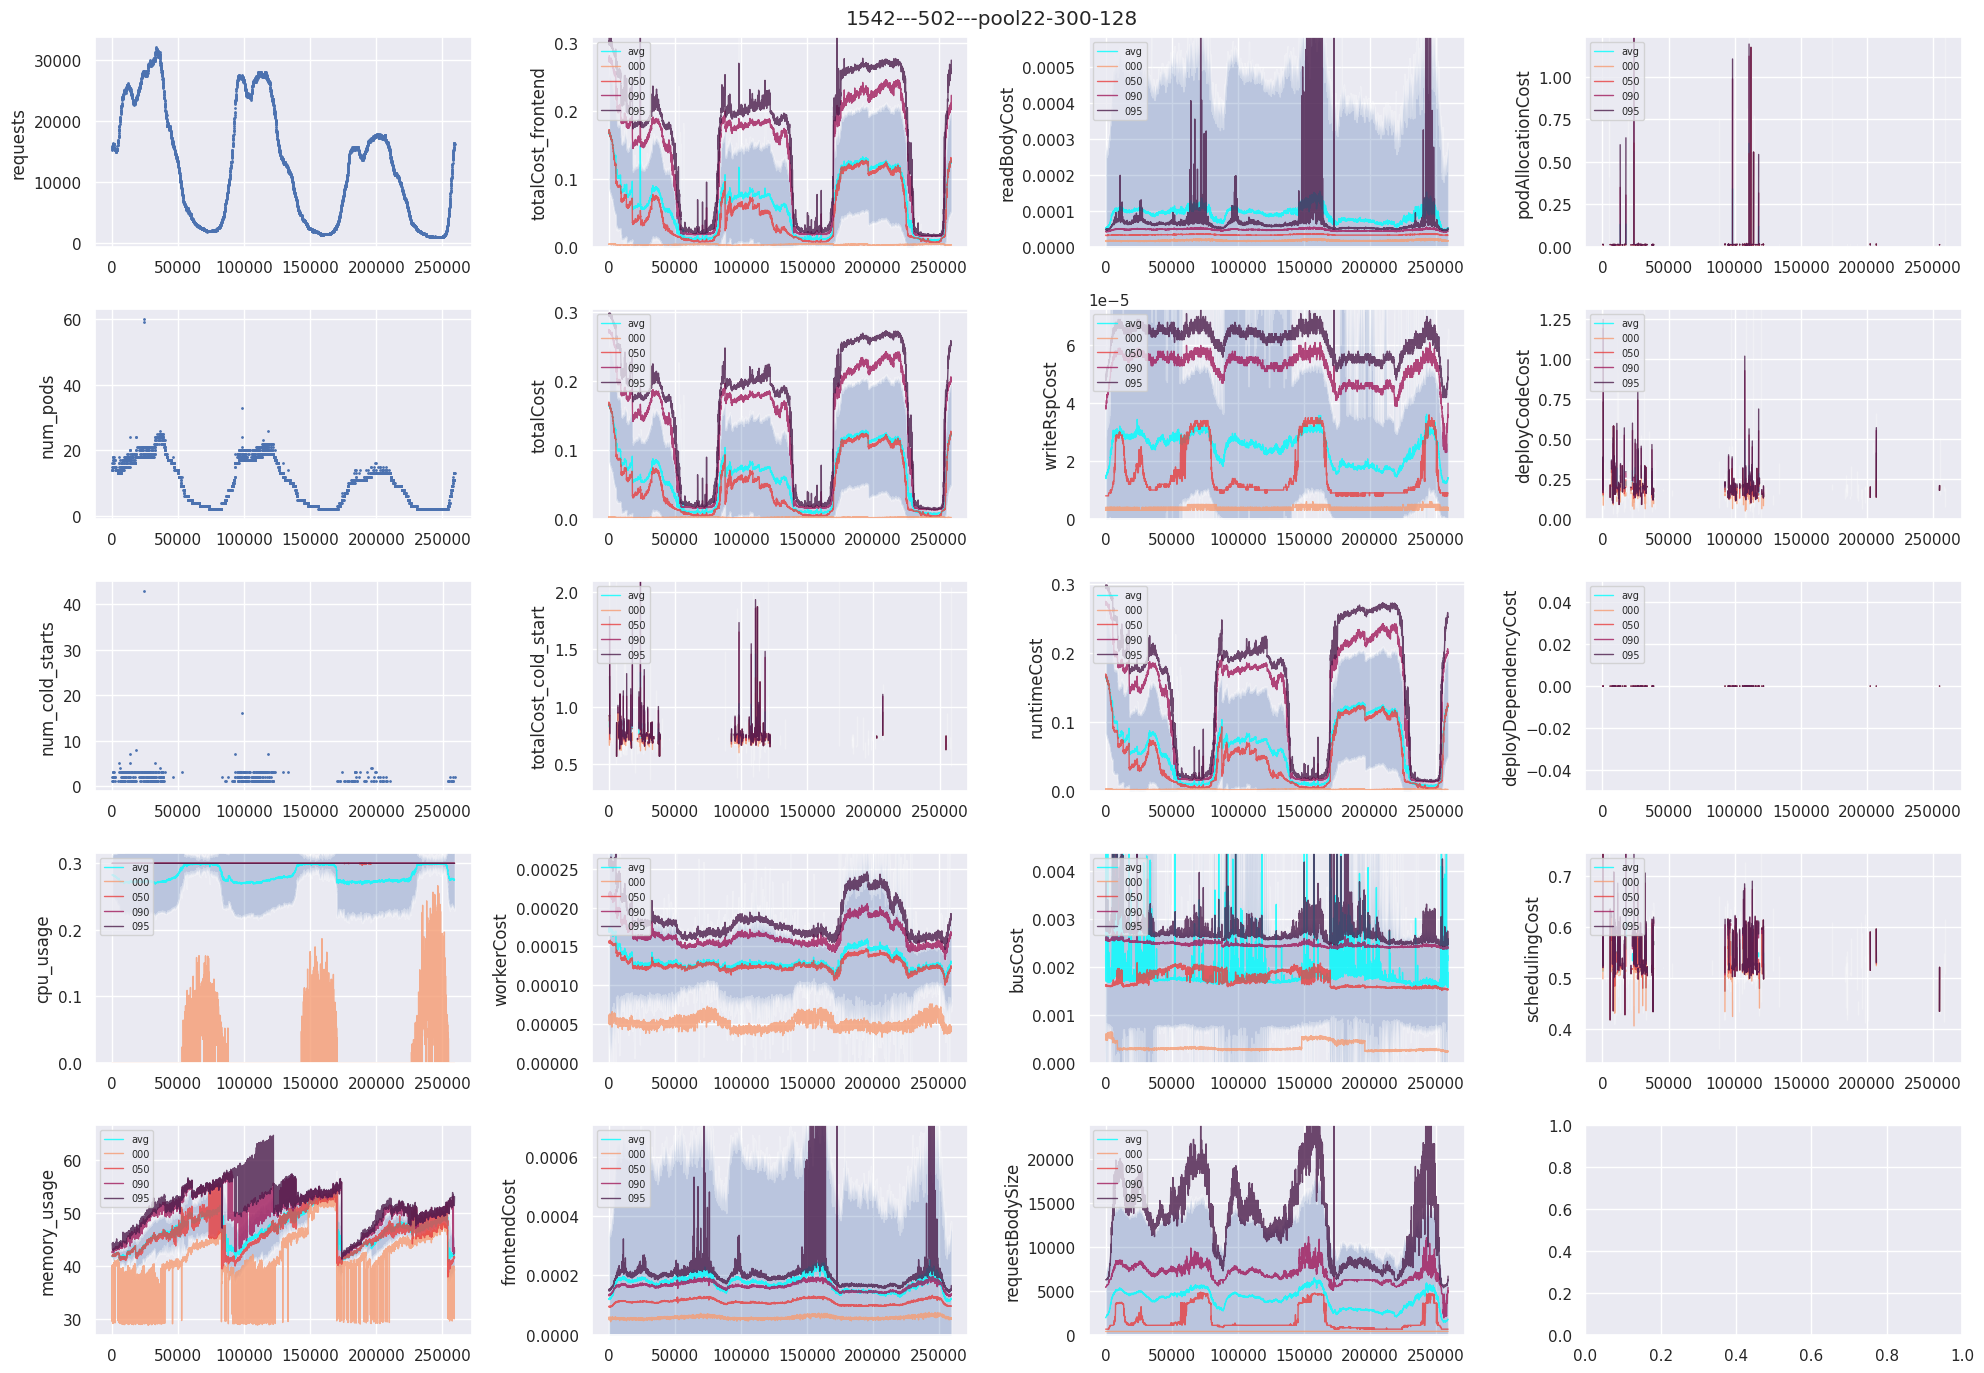

 40%|████      | 4/10 [00:15<00:24,  4.02s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


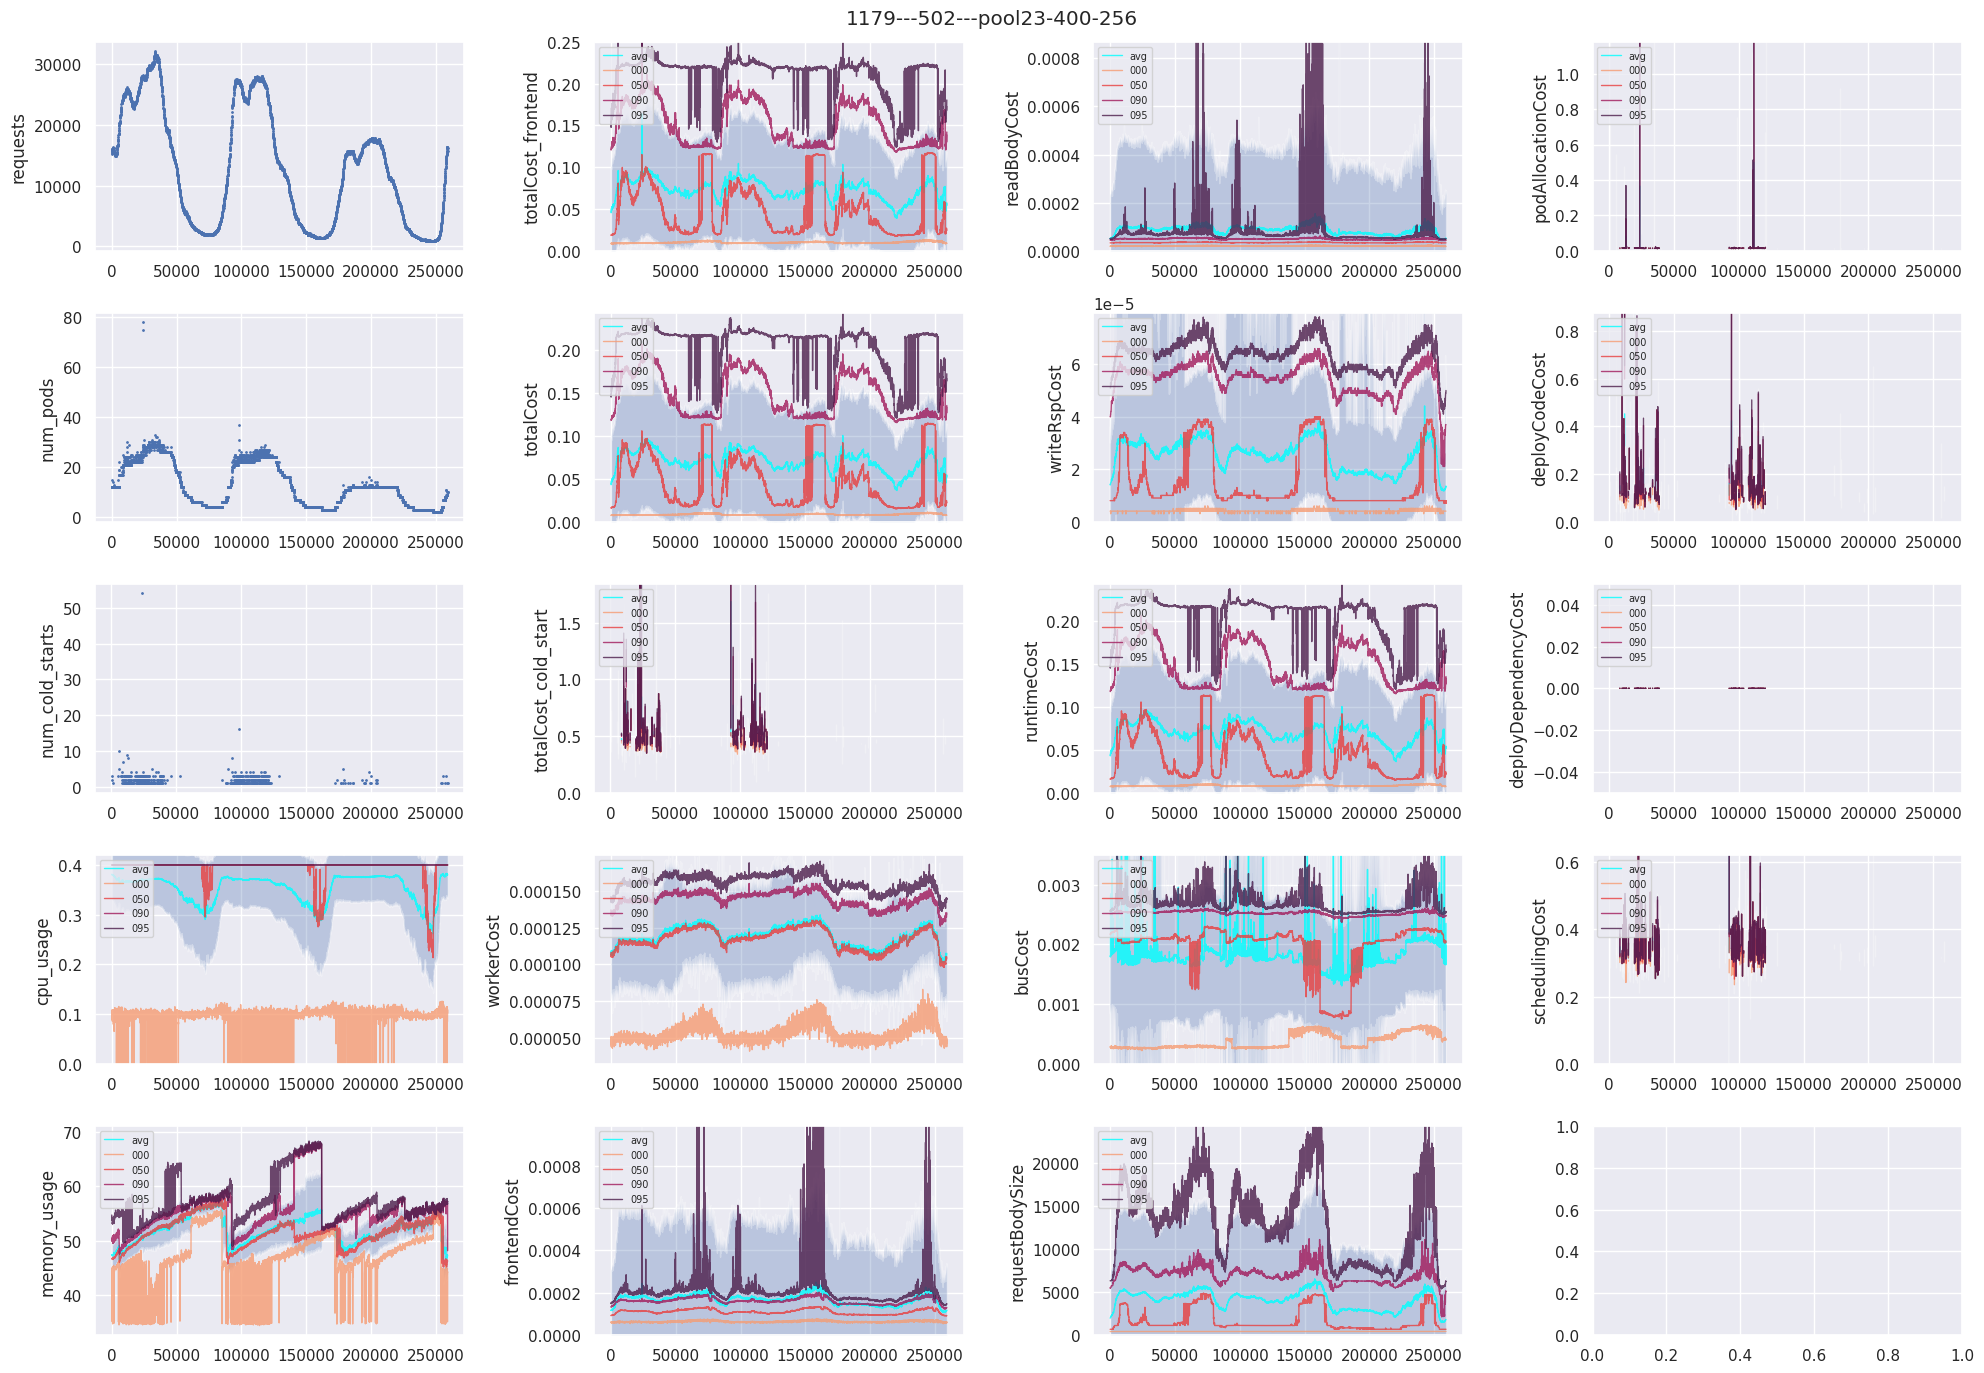

 50%|█████     | 5/10 [00:19<00:20,  4.05s/it]


No metrics left


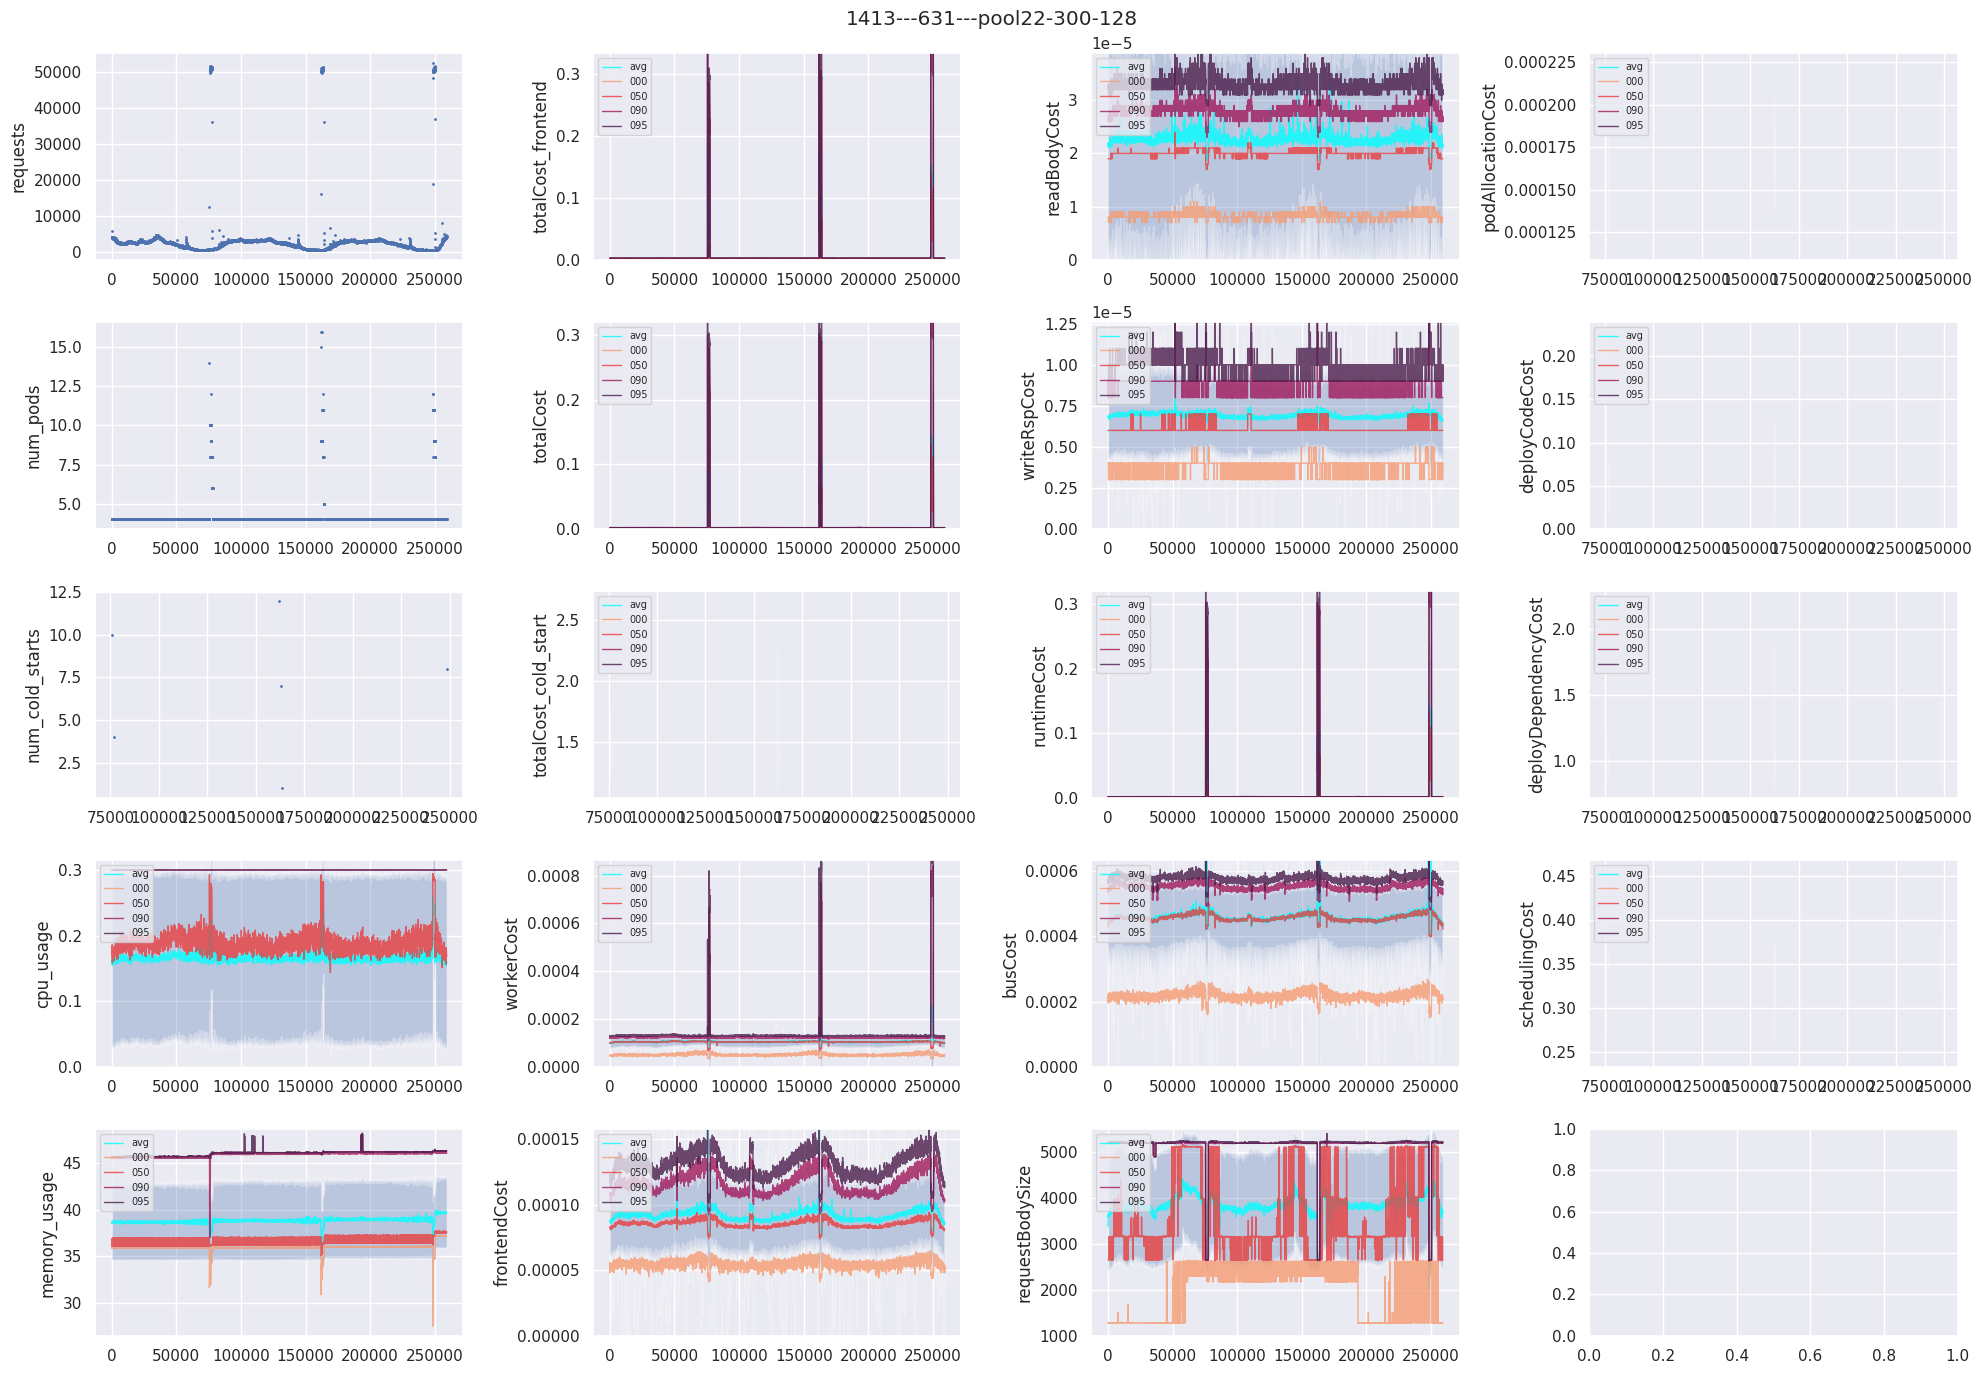

 60%|██████    | 6/10 [00:23<00:15,  3.97s/it]


No metrics left


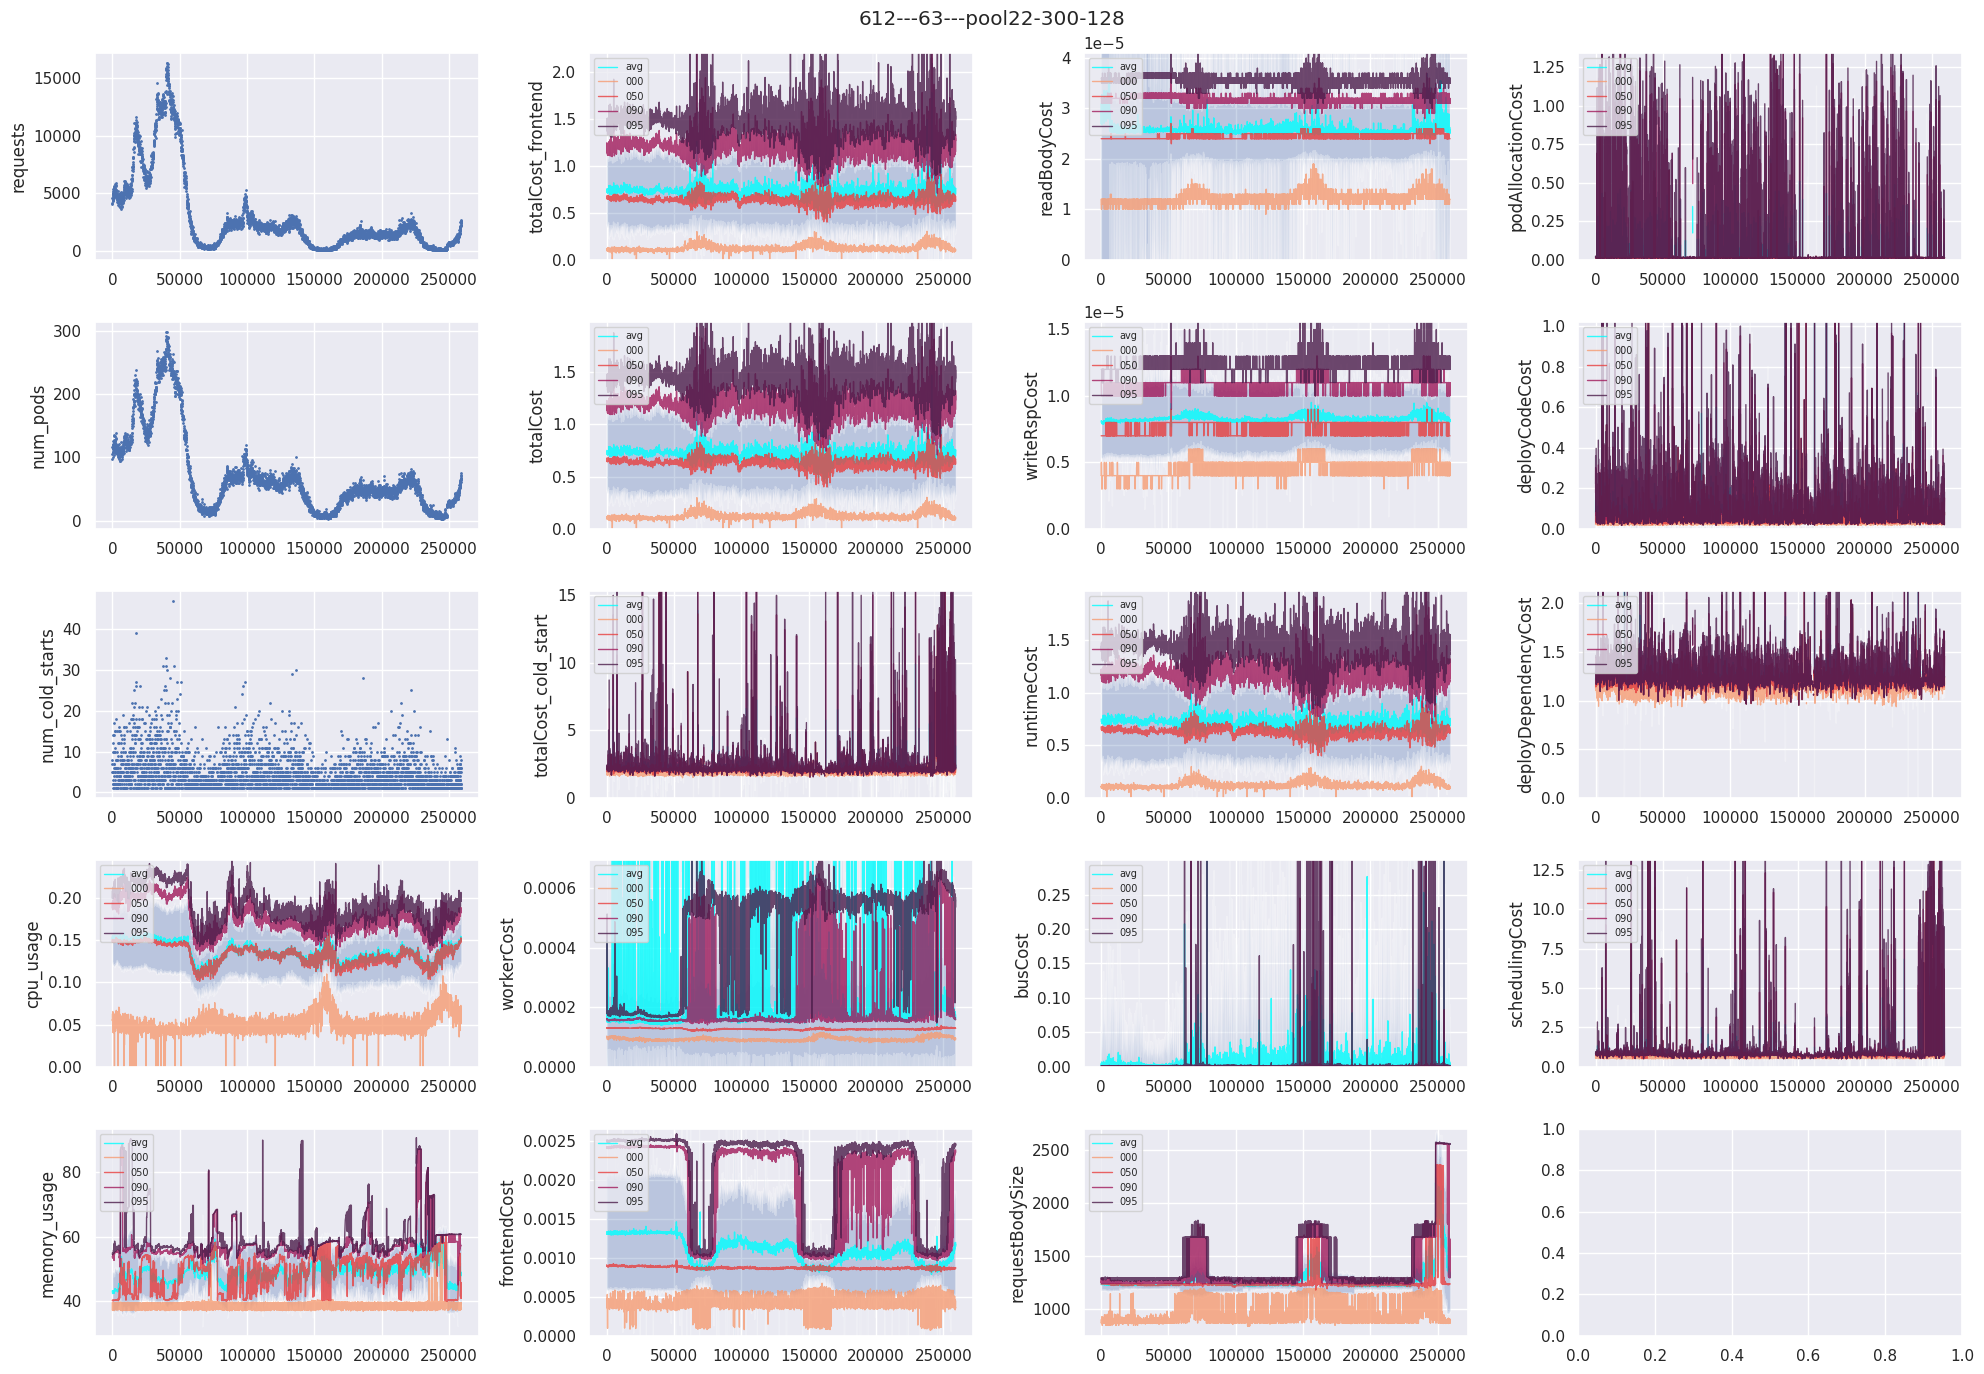

 70%|███████   | 7/10 [00:28<00:12,  4.14s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


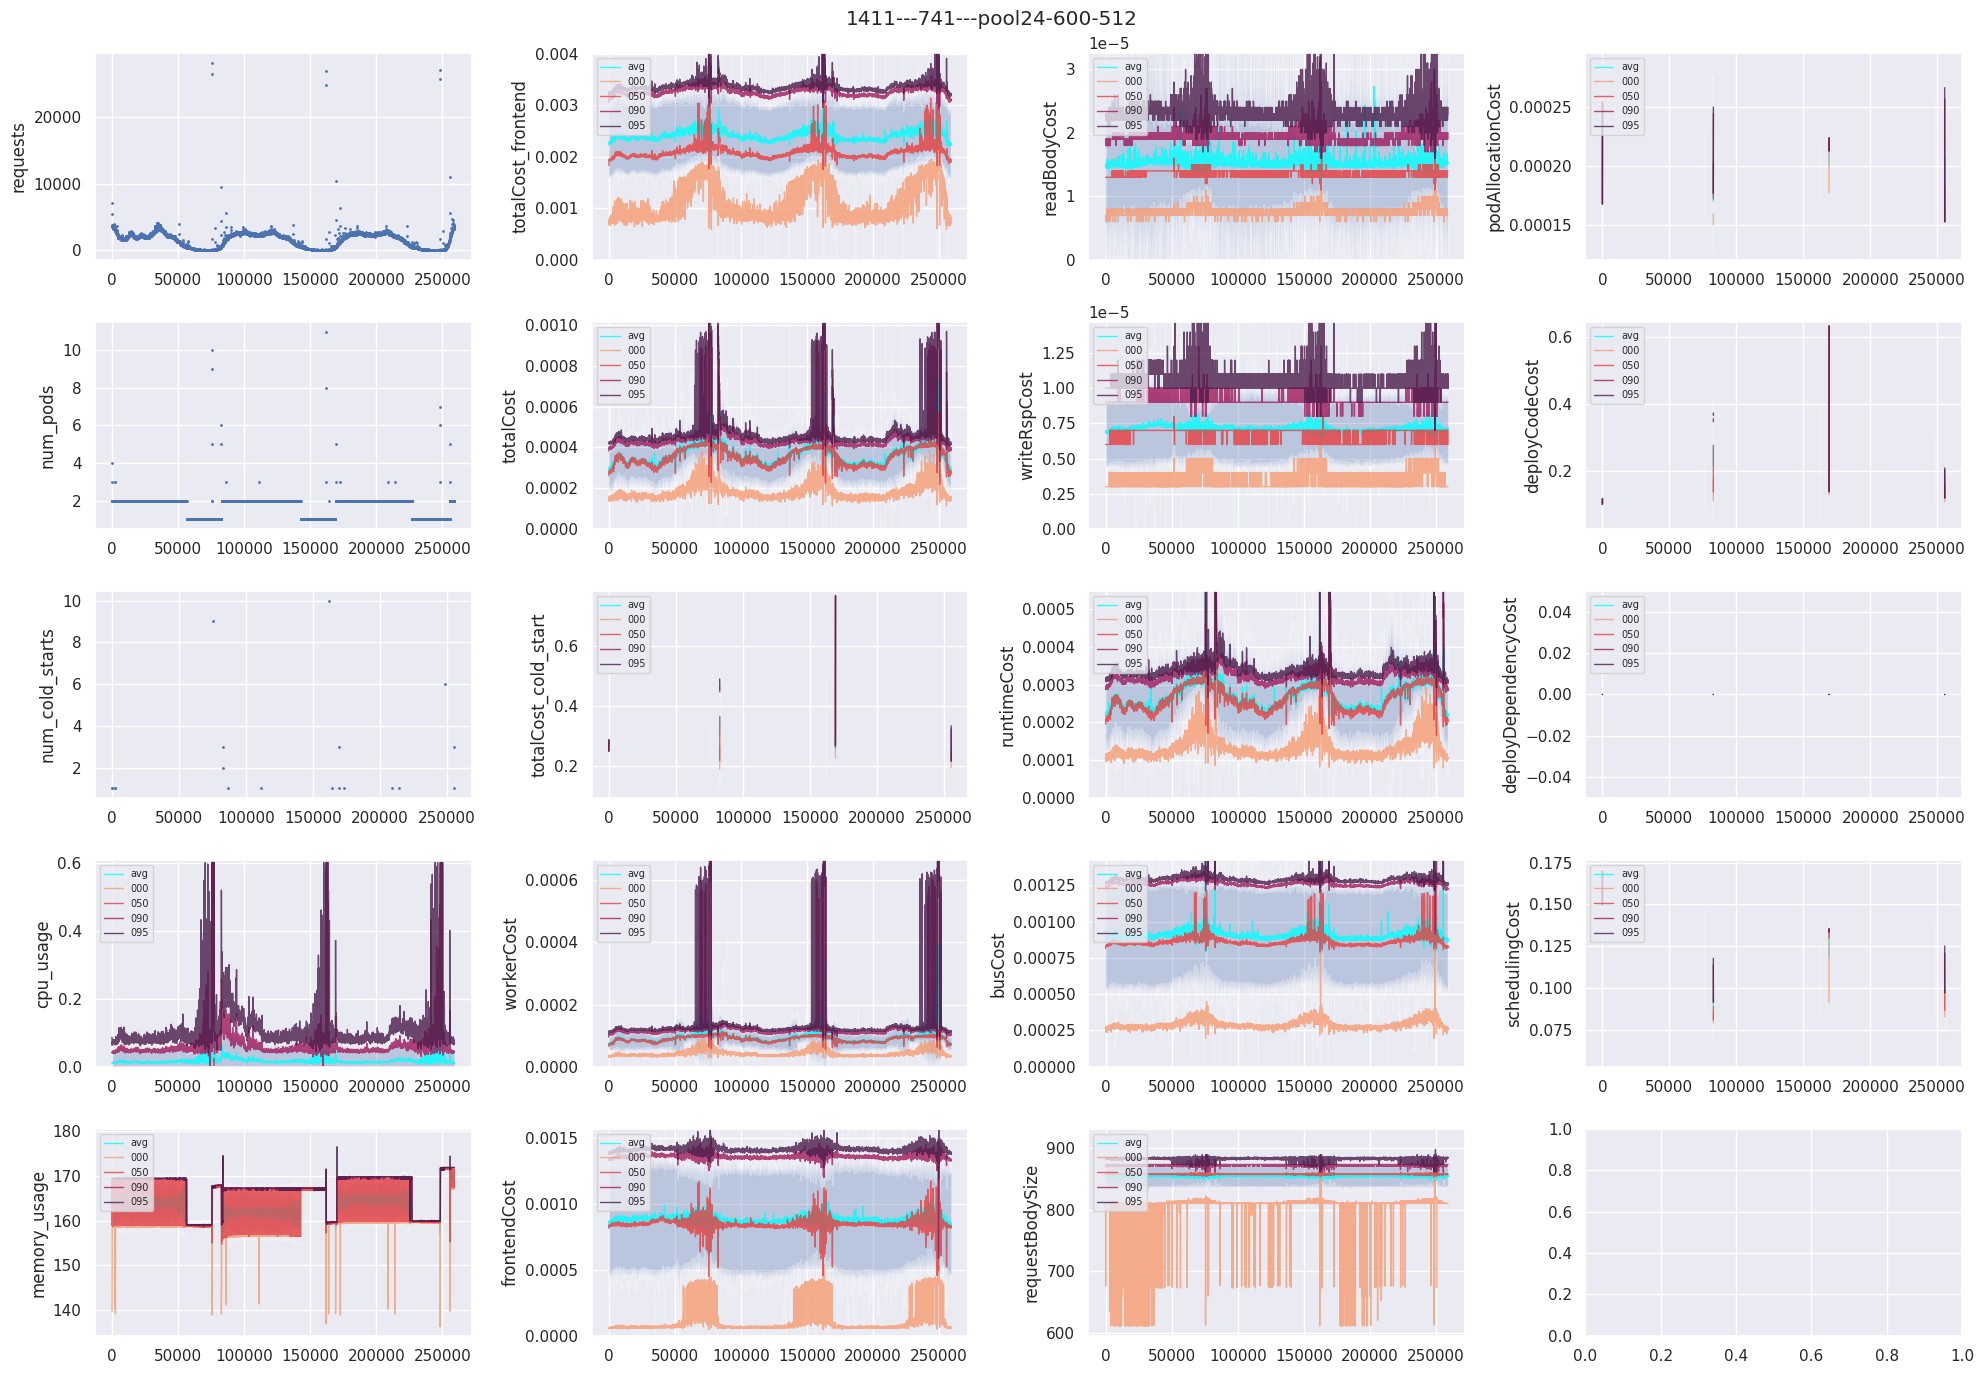

 80%|████████  | 8/10 [00:32<00:08,  4.03s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


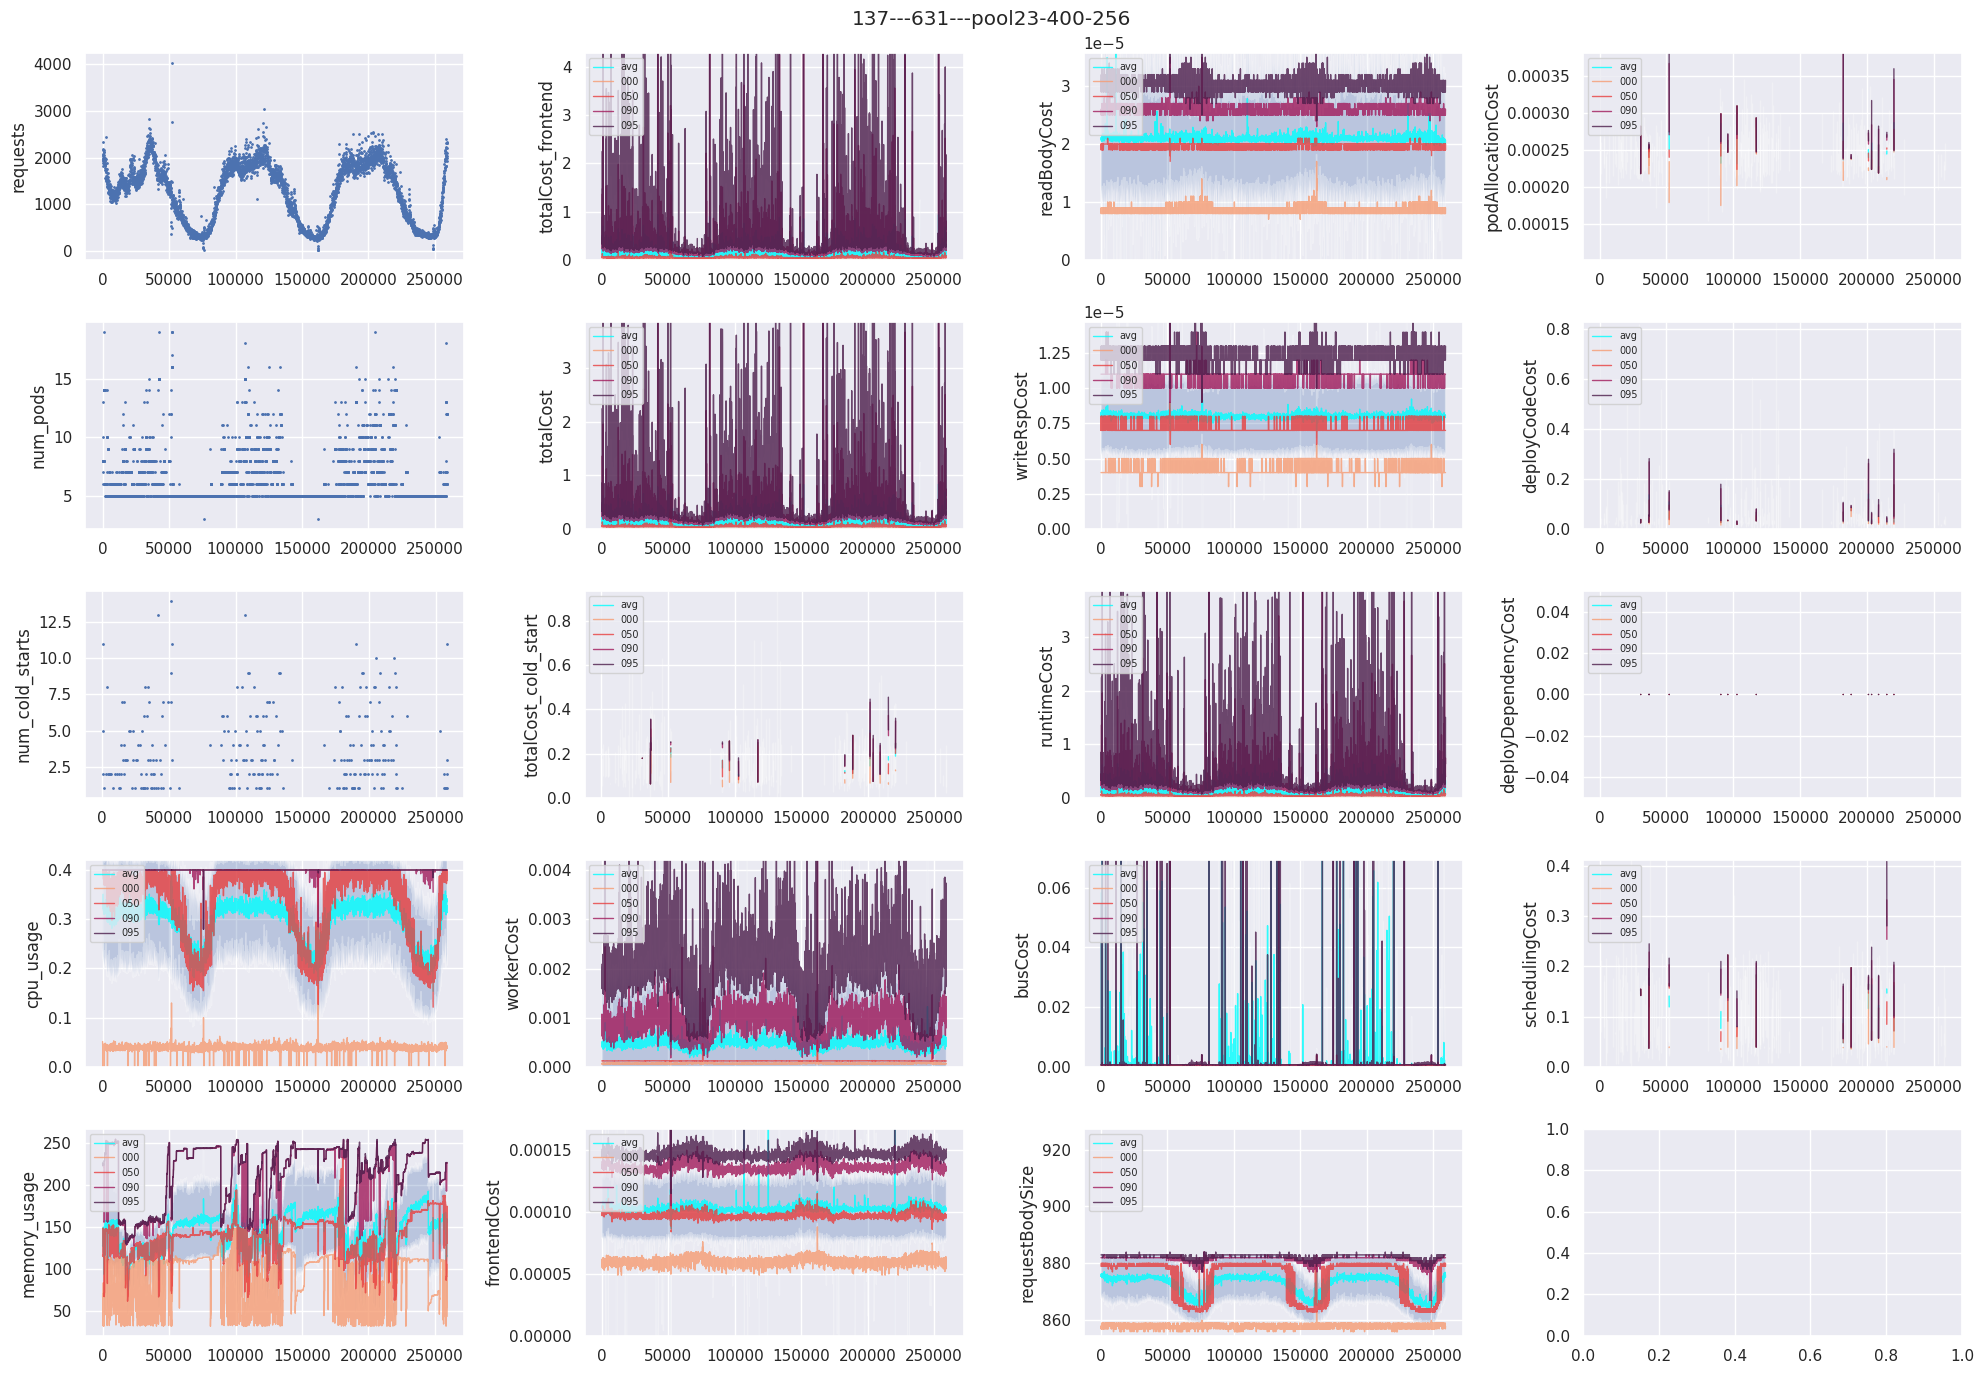

 90%|█████████ | 9/10 [00:36<00:04,  4.08s/it]/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)
/tmp/ipykernel_32147/3302516797.py:53: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)



No metrics left


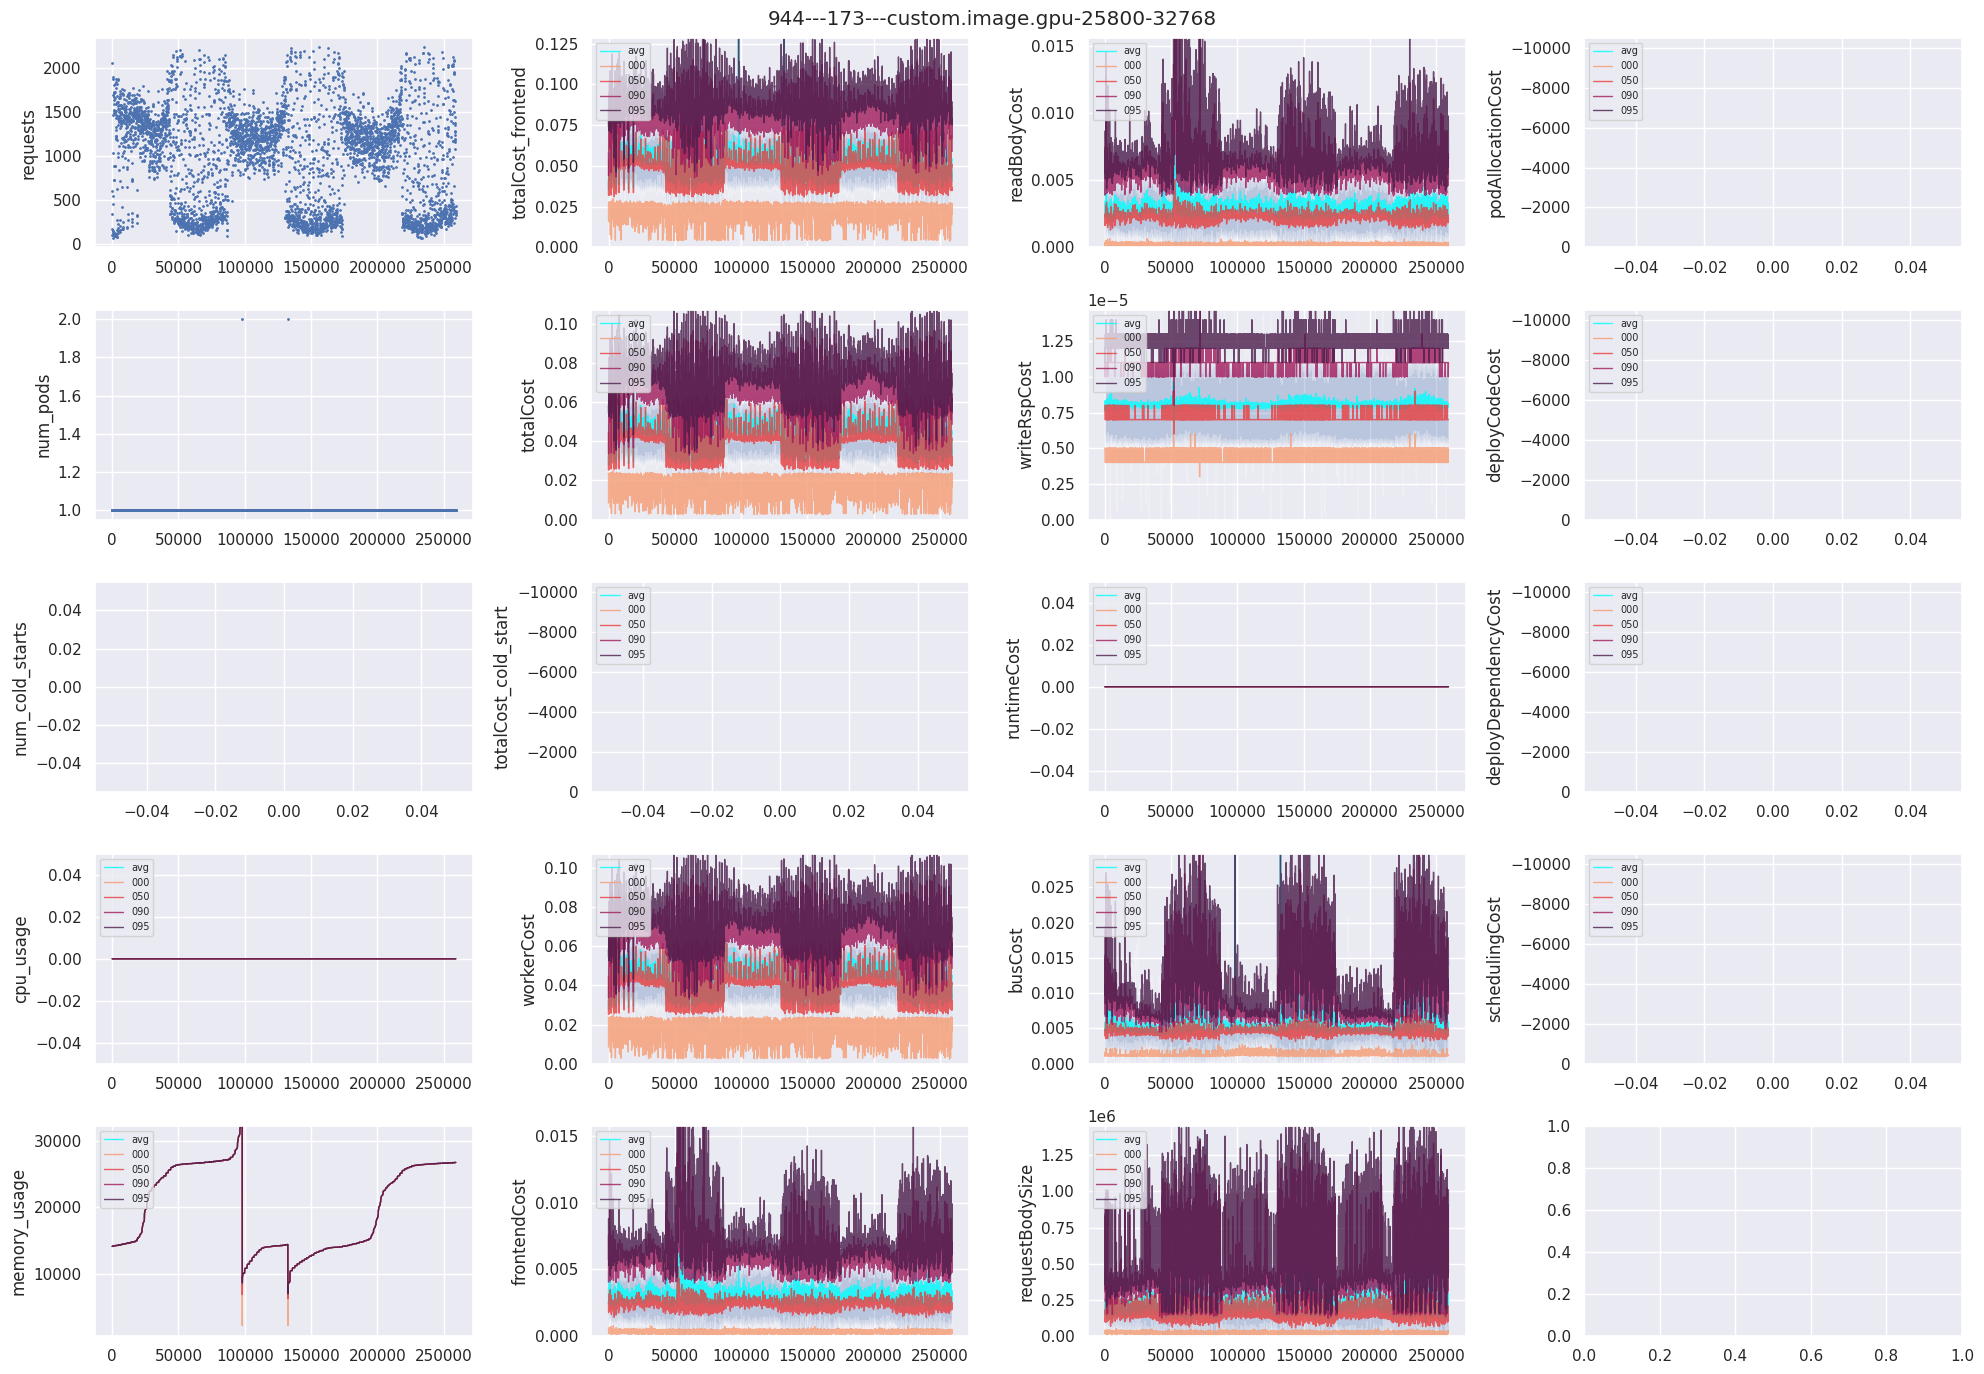

100%|██████████| 10/10 [00:40<00:00,  4.02s/it]


In [18]:
for funcID in tqdm(funcID_list):

    ordered_metrics_family_list = list(metrics_dict.keys())
    ordered_metrics_family_list = iter(ordered_metrics_family_list)

    # Create a 4-row subplot layout
    fig, ax = plt.subplots(5, 4, figsize=(20, 14))

    # Iterate over different metrics
    for col_idx in [0,1,2,3]:

        for row_idx in [0,1,2,3,4]:

            try:
                metric_family = next(ordered_metrics_family_list)
                metric_family_dict = metrics_dict[metric_family]

                if len(metric_family_dict)==1:
                    df_i = metric_family_dict['sum']

                    ax[row_idx, col_idx].scatter(df_i['time'], df_i[funcID], s=1)
                    ax[row_idx, col_idx].set_ylabel(metric_family)

                else:
                    
                    # Avg and std plots
                    ax[row_idx, col_idx].plot(metric_family_dict['avg']['time'], metric_family_dict['avg'][funcID], label = 'avg', c='cyan', alpha=0.8, linewidth=1)

                    std_upper = metric_family_dict['avg'][funcID] - metric_family_dict['std'][funcID]
                    std_lower = metric_family_dict['avg'][funcID] + metric_family_dict['std'][funcID]
                    ax[row_idx, col_idx].fill_between(metric_family_dict['avg']['time'], std_lower, std_upper, alpha=0.3, facecolor='b')
                    

                    # Quantile plots
                    q_list = sorted(metric_family_dict.keys())
                    q_list = [item for item in q_list if 'quantile' in item]
                    
                    max_ylim = -9999
                    c_list = sns.color_palette('rocket_r', len(q_list))
                    for i, q_i in enumerate(q_list):
                        df_q_i = metric_family_dict[q_i]
                        ax[row_idx, col_idx].plot(df_q_i['time'], df_q_i[funcID], label = q_i.replace('quantile_','').replace(metric_family,''), c=c_list[i], alpha=0.8, linewidth=1)
                        ax[row_idx, col_idx].set_ylabel(metric_family)

                        max_ylim_i = df_q_i[funcID].quantile(0.99)
                        if max_ylim<max_ylim_i:
                            max_ylim = max_ylim_i

                    ax[row_idx, col_idx].legend(loc = 'upper left', fontsize=7)             

                    ax[row_idx, col_idx].set_ylim(None, max_ylim*1.05)
                    if ax[row_idx, col_idx].get_ylim()[0]<0:
                        ax[row_idx, col_idx].set_ylim(0, max_ylim*1.05)
            except Exception as e:
                print(e)
                print('No metrics left\r')

    fig.suptitle(funcID)

    plt.tight_layout()
    plt.show()


# Region 2 with runtimes and trigger types
This section explains how to load the runtime and trigger type information for Region 2, and how to join this with the other tables.

In [3]:
df_runtime_triggerType = pd.read_csv(rt_funcID_runtime_triggerType)
df_runtime_triggerType

funcID  cpu_request  runtime  \
0       400---418---pool22-300-128          100  Python3   
1      1531---418---pool22-300-128          100  Node.js   
2      343---1077---pool22-300-128          100     Java   
3       343---420---pool22-300-128          100     Java   
4      343---1095---pool22-300-128          100     Java   
...                            ...          ...      ...   
2413  565---486---pool30-1800-2048         1000     http   
2414   1060---777---pool23-400-256          125  Python3   
2415    673---777---pool23-400-256          125  Python3   
2416   1812---777---pool23-400-256          125  Python3   
2417   2134---777---pool23-400-256          125  Python3   

     triggerType-invocationType  
0                    workflow-S  
1                    workflow-S  
2                    workflow-S  
3                    workflow-S  
4                    workflow-S  
...                         ...  
2413                     APIG-S  
2414            unknown-unknown  
2415            unknown-unknown  
2416            unknown-unknown  
2417            unknown-unknown  

[2418 rows x 4 columns]

<Axes: title={'center': 'Number of functions by runtime'}, xlabel='runtime'>

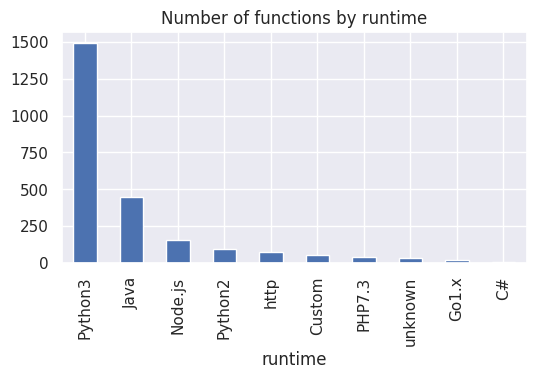

In [4]:
df_runtime_triggerType['runtime'].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), title='Number of functions by runtime')

<Axes: title={'center': 'Number of functions by trigger combination'}, xlabel='triggerType-invocationType'>

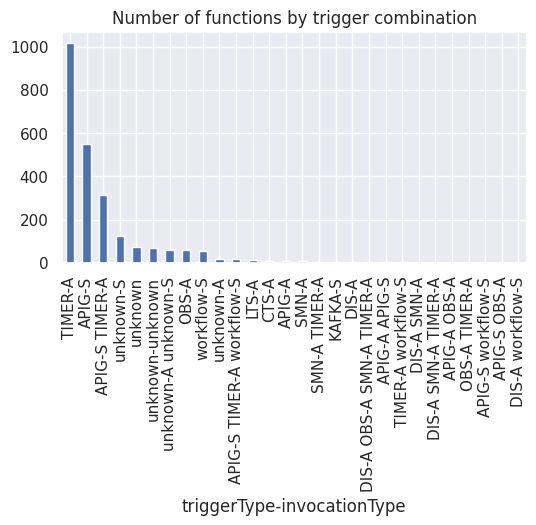

In [5]:
df_runtime_triggerType['triggerType-invocationType'].value_counts(dropna=False).plot(kind='bar', figsize=(6,3), title='Number of functions by trigger combination')

In [6]:
# Read cold starts for Region 2

filenames_list_i = sorted(glob(rt_cold_start+f'/R2/*.csv'))
dfs_list = []
for filename_i in tqdm(filenames_list_i):
    df_i = pd.read_csv(filename_i)
    dfs_list.append(df_i)
df_R2 = pd.concat(dfs_list)
df_R2['poolName'] = df_R2['podID'].str.split('-').str[:3].str.join('-')
df_R2['funcID'] = df_R2['funcName'].astype(str) + '---' + df_R2['userID'].astype(str) + '---' + df_R2['poolName']
df_R2

100%|██████████| 31/31 [00:05<00:00,  5.84it/s]


day         time  clusterName  funcName  userID  \
0        0        0.323            1       979    1111   
1        0        0.328            2       743     418   
2        0        0.361            3      2028     481   
3        0        0.362            3       167     296   
4        0        0.364            3       272     525   
...    ...          ...          ...       ...     ...   
63144   30  2678388.653            2      1607     923   
63145   30  2678390.987            1       612      63   
63146   30  2678391.260            1       612      63   
63147   30  2678391.320            1       612      63   
63148   30  2678395.264            2      1483     709   

                                               requestID  \
0      e8cc4228b32e4a8fcf7c164ca62cf5a1569305bb7d3121...   
1      f554e1c7fa2222b458d5764910e2d1ee3bccd2045fefce...   
2      58b18460d4fc4a6e8419f1f7bf6da422cc3671e747974f...   
3      f951318dc8f7e4b17ccb1fa907730aa95b3b36743a4327...   
4      2a83c6c486f8e4b5efc798fb44f4401b5d16199f8eefd5...   
...                                                  ...   
63144  fc8e24a3cf7fbce54ed3e24d99b11ed7933e4fd1cdffda...   
63145  ac3f447c0ee16ecf709eeab0260156efba024e15c5e7a6...   
63146  fe7b641cb13d744d06ee954202df62dced52794b2a9504...   
63147  9265d3477e5af0a8dde659dd878f7f1e58b4d699275a64...   
63148  52a91dd50b12cca0465063182676ea3deac42d4761c655...   

       totalCost_cold_start  podAllocationCost  deployCodeCost  \
0                  0.289404           0.000243           0.213   
1                  0.172102           0.000138           0.067   
2                  0.235527           0.000138           0.125   
3                  0.167989           0.000123           0.055   
4                  0.215433           0.000152           0.074   
...                     ...                ...             ...   
63144              0.597362           0.014675           0.136   
63145              1.450608           0.007911           0.025   
63146              1.720289           0.007843           0.028   
63147              1.793164           0.007897           0.052   
63148              1.205189           0.000287           0.034   

       deployDependencyCost  schedulingCost                      podID  \
0                     0.000        0.076161  pool22-300-128-0001562370   
1                     0.000        0.104964  pool22-300-128-0000600630   
2                     0.000        0.110389  pool22-300-128-0001444785   
3                     0.000        0.112866  pool22-300-128-0001443980   
4                     0.000        0.141281  pool22-300-128-0001092850   
...                     ...             ...                        ...   
63144                 0.000        0.446687  pool22-300-128-0000196449   
63145                 0.983        0.434697  pool22-300-128-0001377502   
63146                 1.271        0.413446  pool22-300-128-0000044339   
63147                 1.217        0.516267  pool22-300-128-0001700101   
63148                 0.000        1.170902  pool22-300-128-0000126869   

             poolName                       funcID  
0      pool22-300-128  979---1111---pool22-300-128  
1      pool22-300-128   743---418---pool22-300-128  
2      pool22-300-128  2028---481---pool22-300-128  
3      pool22-300-128   167---296---pool22-300-128  
4      pool22-300-128   272---525---pool22-300-128  
...               ...                          ...  
63144  pool22-300-128  1607---923---pool22-300-128  
63145  pool22-300-128    612---63---pool22-300-128  
63146  pool22-300-128    612---63---pool22-300-128  
63147  pool22-300-128    612---63---pool22-300-128  
63148  pool22-300-128  1483---709---pool22-300-128  

[2072823 rows x 14 columns]

In [7]:
# Merge with runtimes and trigger types based on funcID
df_R2 = pd.merge(left=df_R2, right=df_runtime_triggerType, on='funcID', how='left')
df_R2

day         time  clusterName  funcName  userID  \
0          0        0.323            1       979    1111   
1          0        0.328            2       743     418   
2          0        0.361            3      2028     481   
3          0        0.362            3       167     296   
4          0        0.364            3       272     525   
...      ...          ...          ...       ...     ...   
2072818   30  2678388.653            2      1607     923   
2072819   30  2678390.987            1       612      63   
2072820   30  2678391.260            1       612      63   
2072821   30  2678391.320            1       612      63   
2072822   30  2678395.264            2      1483     709   

                                                 requestID  \
0        e8cc4228b32e4a8fcf7c164ca62cf5a1569305bb7d3121...   
1        f554e1c7fa2222b458d5764910e2d1ee3bccd2045fefce...   
2        58b18460d4fc4a6e8419f1f7bf6da422cc3671e747974f...   
3        f951318dc8f7e4b17ccb1fa907730aa95b3b36743a4327...   
4        2a83c6c486f8e4b5efc798fb44f4401b5d16199f8eefd5...   
...                                                    ...   
2072818  fc8e24a3cf7fbce54ed3e24d99b11ed7933e4fd1cdffda...   
2072819  ac3f447c0ee16ecf709eeab0260156efba024e15c5e7a6...   
2072820  fe7b641cb13d744d06ee954202df62dced52794b2a9504...   
2072821  9265d3477e5af0a8dde659dd878f7f1e58b4d699275a64...   
2072822  52a91dd50b12cca0465063182676ea3deac42d4761c655...   

         totalCost_cold_start  podAllocationCost  deployCodeCost  \
0                    0.289404           0.000243           0.213   
1                    0.172102           0.000138           0.067   
2                    0.235527           0.000138           0.125   
3                    0.167989           0.000123           0.055   
4                    0.215433           0.000152           0.074   
...                       ...                ...             ...   
2072818              0.597362           0.014675           0.136   
2072819              1.450608           0.007911           0.025   
2072820              1.720289           0.007843           0.028   
2072821              1.793164           0.007897           0.052   
2072822              1.205189           0.000287           0.034   

         deployDependencyCost  schedulingCost                      podID  \
0                       0.000        0.076161  pool22-300-128-0001562370   
1                       0.000        0.104964  pool22-300-128-0000600630   
2                       0.000        0.110389  pool22-300-128-0001444785   
3                       0.000        0.112866  pool22-300-128-0001443980   
4                       0.000        0.141281  pool22-300-128-0001092850   
...                       ...             ...                        ...   
2072818                 0.000        0.446687  pool22-300-128-0000196449   
2072819                 0.983        0.434697  pool22-300-128-0001377502   
2072820                 1.271        0.413446  pool22-300-128-0000044339   
2072821                 1.217        0.516267  pool22-300-128-0001700101   
2072822                 0.000        1.170902  pool22-300-128-0000126869   

               poolName                       funcID  cpu_request  runtime  \
0        pool22-300-128  979---1111---pool22-300-128          100  Python3   
1        pool22-300-128   743---418---pool22-300-128          100  Node.js   
2        pool22-300-128  2028---481---pool22-300-128          100  Node.js   
3        pool22-300-128   167---296---pool22-300-128          100  Node.js   
4        pool22-300-128   272---525---pool22-300-128          100  Python3   
...                 ...                          ...          ...      ...   
2072818  pool22-300-128  1607---923---pool22-300-128          100  Python3   
2072819  pool22-300-128    612---63---pool22-300-128          100  Python3   
2072820  pool22-300-128    612---63---pool22-300-128          100  Python3   
2072821  pool22-300-128    612---

In [8]:
df_R2['runtime'].value_counts(dropna=False)

runtime
Python3    1190731
Node.js     287253
Custom      186452
Java        165695
Python2     165673
Go1.x        30045
PHP7.3       25591
http         18167
C#            3105
unknown        111
Name: count, dtype: int64

<Axes: xlabel='totalCost_cold_start', ylabel='Probability'>

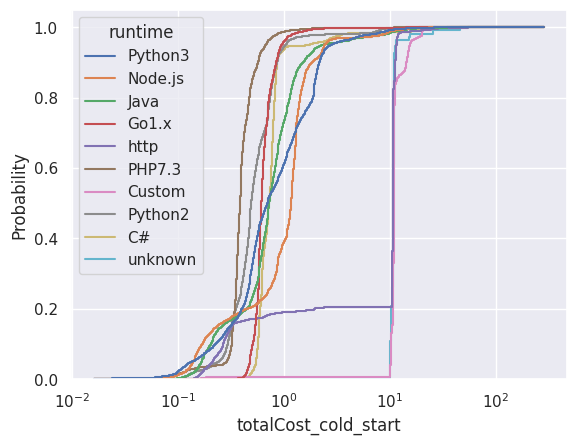

In [10]:
# CDF of cold start time by runtime language
sns.histplot(data=df_R2, 
             bins=500,
             fill=False,
             element="step",
             x='totalCost_cold_start', 
             hue='runtime', 
             stat='probability', 
             cumulative=True, 
             log_scale=[True,False], 
             common_norm=False)

## Per request analysis
This section explains how to analyze the request-level logs. The code below works for smaller regions. For larger regions, you may have to use PySpark or other big data tools.

In [18]:
region = 'R5'

In [19]:
rt = f'../datasets/cold_start_dataset/per_request/{region}/*.csv'

In [20]:
filenames_list = sorted(glob(rt))
print(f'Found {len(filenames_list)} per request files')

Found 200 per request files


In [21]:
dfs_list = []
for filename_i in tqdm(filenames_list):
    df_i = pd.read_csv(filename_i)
    dfs_list.append(df_i)
df = pd.concat(dfs_list)
df

100%|██████████| 200/200 [00:10<00:00, 19.00it/s]


time_worker  time_frontend  \
0      2592000.020    2592000.021   
1      2592000.034    2592000.037   
2      2592000.040    2592000.041   
3      2592000.052    2592000.052   
4      2592000.066    2592000.066   
...            ...            ...   
16157  2678398.958            NaN   
16158  2678398.995            NaN   
16159  2678399.020            NaN   
16160  2678399.048            NaN   
16161  2678399.087            NaN   

                                               requestID  clusterName  \
0      b54cf4cd859e62637c91fd47cef816f291a9efec3b9d17...            3   
1      987863989fbd048b38594549e69b7c7f4b102d3543e663...            3   
2      60a99140327936a024c9329aba7b4fd5313eedd8b16e14...            3   
3      cfe3d0a027c55dd500d9c49a1d4be156e789dfc4e062be...            4   
4      bdf1779d87d3dc9cee9ded2df86d33dcef0c95a94c872b...            4   
...                                                  ...          ...   
16157  bdea9699d7062c7a530b63f49e14b9c2864cc0a9621084...            4   
16158  6097886824be9995d96b84f5baa926a0c1f89048746c81...            4   
16159  dcd6ca5c39280d164f0e32d758baf77b09e182131ec6b7...            4   
16160  f0c9211944e6cf928d880f395229a47302f3b1eef5d8fe...            4   
16161  e554029e37642ebfde15e7ef06175e595780e914fa1854...            4   

       funcName                      podID  userID  totalCost_worker  \
0           411  pool22-300-128-0000177166     301          0.000931   
1            34  pool22-300-128-0000014767      83          0.001416   
2           329  pool22-300-128-0000331366     301          0.000823   
3           296  pool22-300-128-0000618412     224          0.019952   
4           296  pool22-300-128-0000773449     224          0.034748   
...         ...                        ...     ...               ...   
16157       296  pool22-300-128-0000206093     224          0.027996   
16158       296  pool22-300-128-0000206093     224          0.036471   
16159       296  pool22-300-128-0000206093     224          0.024943   
16160       296  pool22-300-128-0000206093     224          0.027543   
16161       296  pool22-300-128-0000206093     224          0.038679   

       workerCost  runtimeCost  totalCost_frontend  frontendCost   busCost  \
0        0.000103     0.000829            0.002367      0.000531  0.000585   
1        0.000646     0.000770            0.011992      0.000377  0.009904   
2        0.000131     0.000692            0.003945      0.002248  0.000540   
3        0.000124     0.019828            0.022946      0.000444  0.002194   
4        0.000143     0.034605            0.037435      0.000556  0.001785   
...           ...          ...                 ...           ...       ...   
16157    0.000100     0.027896                 NaN           NaN       NaN   
16158    0.000103     0.036368                 NaN           NaN       NaN   
16159    0.000103     0.024840                 NaN           NaN       NaN   
16160    0.000100     0.027444                 NaN           NaN       NaN   
16161    0.000111     0.038568                 NaN           NaN       NaN   

       readBodyCost  writeRspCost  cpu_usage  memory_usage  requestBodySize  
0          0.000025      0.000009   0.059806     34.238280              2.0  
1          0.000018      0.000008   0.000000     26.699219            120.0  
2          0.000021      0.000008   0.000000     26.652344              2.0  
3          0.000024      0.000009   0.290779     32.304688            979.0  
4          0.000033      0.000013   0.219951     32.378906            979.0  
...             ...           ...        ...           ...              ...  
16157           NaN           NaN   0.231319     32.324220              NaN  
16158           NaN           NaN   0.179856     32.324220              NaN  
16159           NaN           NaN   0.238961     32.324220              NaN  
16160           NaN           NaN   0.254372     32.324220              NaN  
16161           NaN      

In [22]:
df.dtypes

time_worker           float64
time_frontend         float64
requestID              object
clusterName             int64
funcName                int64
podID                  object
userID                  int64
totalCost_worker      float64
workerCost            float64
runtimeCost           float64
totalCost_frontend    float64
frontendCost          float64
busCost               float64
readBodyCost          float64
writeRspCost          float64
cpu_usage             float64
memory_usage          float64
requestBodySize       float64
dtype: object